# Exploratory Data Analysis

In [1]:
import os
import re
import glob
import math
import random
import datetime

# data processing
import pandas as pd
import numpy as np

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
SEED = 42
seed_everything(SEED)

## 1. Load Data

In [4]:
root = '../../input'
train_path = f'{root}/train.csv'
sample_submission_path = f'{root}/sample_submission.csv'

In [6]:
df = pd.read_csv(train_path, parse_dates=["order_date"])
df.head()

order_id product_id                          description  quantity  \
0   489434      85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434     79323P                   PINK CHERRY LIGHTS        12   
2   489434     79323W                  WHITE CHERRY LIGHTS        12   
3   489434      22041         RECORD FRAME 7" SINGLE SIZE         48   
4   489434      21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           order_date    price  customer_id         country   total  
0 2009-12-01 07:45:00  11.4675        13085  United Kingdom  137.61  
1 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65  
2 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65  
3 2009-12-01 07:45:00   3.4650        13085  United Kingdom  166.32  
4 2009-12-01 07:45:00   2.0625        13085  United Kingdom   49.50

## 2. Overview

In [ ]:
df.info()

모든 column에서 `non-null`인 것으로 보아 결측치는 없는 것으로 보인다.

In [ ]:
print('로그 시작 날짜:', df.order_date.min())
print('로그 마지막 날짜:', df.order_date.max())

2009년 12월 1일부터 2011년 11월 30일까지의 데이터가 저장되어 있다.

In [ ]:
print('고객의 명수:', len(df.customer_id.unique()))

고객은 총 5914명으로 5914명의 미래 총 구매액을 예측해야 한다.

In [10]:
# 임의로 고객 한 명을 선정
sample_customer = int(df.customer_id.sample(random_state=SEED))
df[df.customer_id == sample_customer].head(15)

order_id product_id                         description  quantity  \
25957   492368      22336       DOVE DECORATION PAINTED ZINC         30   
25958   492368      21165       BEWARE OF THE CAT METAL SIGN          3   
25959   492368      21980      PACK OF 12 RED SPOTTY TISSUES         12   
25960   492368      21153              RED SPOTTY TABLECLOTH          2   
25961   492368      21539             RETRO SPOTS BUTTER DISH         1   
25962   492368      22335      HEART DECORATION PAINTED ZINC         10   
25963   492368      22155              STAR DECORATION RUSTIC        20   
25964   492368      22095                LADS ONLY TISSUE BOX         4   
25965   492368      22098           BOUDOIR SQUARE TISSUE BOX         4   
25966   492368     35981C   WHITE SNOW SCANDINAVIAN STOCKING         14   
25967   492368      22082         RIBBON REEL STRIPES DESIGN          5   
25968   492368     84997B   RED 3 PIECE MINI DOTS CUTLERY SET         2   
25969   492368     84997D  PINK 3 PIECE MINI DOTS CUTLERY SET         2   
25970   492368      21900                      KEY FOB , SHED         2   
25971   492368      84832    ZINC WILLIE WINKIE  CANDLE STICK         6   

               order_date    price  customer_id         country    total  
25957 2009-12-16 14:08:00   1.0725        14415  United Kingdom  32.1750  
25958 2009-12-16 14:08:00   2.7885        14415  United Kingdom   8.3655  
25959 2009-12-16 14:08:00   0.4785        14415  United Kingdom   5.7420  
25960 2009-12-16 14:08:00  17.5725        14415  United Kingdom  35.1450  
25961 2009-12-16 14:08:00   8.1675        14415  United Kingdom   8.1675  
25962 2009-12-16 14:08:00   1.0725        14415  United Kingdom  10.7250  
25963 2009-12-16 14:08:00   0.6930        14415  United Kingdom  13.8600  
25964 2009-12-16 14:08:00   2.0625        14415  United Kingdom   8.2500  
25965 2009-12-16 14:08:00   2.0625        14415  United Kingdom   8.2500  
25966 2009-12-16 14:08:00   0.6270        14415  United Kingdom   8.7780  
25967 2009-12-16 14:08:00   2.7225        14415  United Kingdom  13.6125  
25968 2009-12-16 14:08:00   6.1875        14415  United Kingdom  12.3750  
25969 2009-12-16 14:08:00   6.1875        14415  United Kingdom  12.3750  
25970 2009-12-16 14:08:00   1.0725        14415  United Kingdom   2.1450  
25971 2009-12-16 14:08:00   1.4025        14415  United Kingdom   8.4150

- 분 단위로 로그가 기록된다.
- 상품이 다르더라도 같은 시간에 구매했다면 `order_id`는 동일하다. (장바구니 같은 개념)
- `product_id`에 숫자 5자리가 아닌 경우도 존재한다.

## 3. Question & Answer

### 3.1. Product ID

##### **Q. `prodict_id`는 중복을 제외하고 총 몇 개가 존재할까?**

In [11]:
print('product_id의 개수', len(df.product_id.unique()))

product_id의 개수 4645


중복을 제외하고 총 4645개이다.

##### **Q. `product_id`는 어떤 규칙으로 구성되어 있을까?**

우선 데이터 설명에 의하면 5개의 숫자로 되어있다고 하였다. 하지만, 앞서 보았던 것처럼 문자가 섞여있는 경우가 존재한다. 문자가 섞여있는 데이터를 추출하기 위해 간단히 `product_id`의 길이를 가지고 데이터를 추출해보았다.

In [12]:
# 데이터의 길이가 5보다 작은 경우
case_less_than_four = [id for id in list(df.product_id.unique()) if len(id) < 5]
print('case_less_than_four:', case_less_than_four)

case_less_than_four: ['POST', 'D', 'M', 'C2', 'PADS', 'DOT', 'CRUK']


In [13]:
# 데이터의 길이가 5인 경우 & 모두 정수로 변환이 가능한 경우
case_equal_five = [int(id) for id in list(df.product_id.unique()) if len(id) == 5]
# 개수가 너무 많아서 개수로 출력
print('case_equal_five의 개수:', len(case_equal_five))

case_equal_five의 개수: 3330


In [14]:
# 데이터의 길이가 5보다 큰 경우
case_more_than_five = [id for id in list(df.product_id.unique()) if len(id) > 5]
print('case_more_than_five의 개수:', len(case_more_than_five))

case_more_than_five의 개수: 1308


In [15]:
# 데이터의 길이가 5보다 큰 경우 & 앞의 5자리가 정수인 경우
case_five_digit_with_str = [id for id in case_more_than_five if id[:5].isdigit()]
print('case_five_digit_with_str의 개수:', len(case_five_digit_with_str))

# 앞의 5자리가 모두 정수로 변환이 가능한지 확인
is_all_digits = all([id[:5].isdigit() for id in case_five_digit_with_str])
print('case_five_digit_with_str의 5자리가 모두 숫자인지 확인:', is_all_digits)

# 뒤에 붙는 알파벳의 종류
alphabets = [id[5:] for id in case_five_digit_with_str if id[5:]]
print('case_five_digit_with_str의 알파벳 종류:\n', list(set(alphabets)))

case_five_digit_with_str의 개수: 1302
case_five_digit_with_str의 5자리가 모두 숫자인지 확인: True
case_five_digit_with_str의 알파벳 종류:
 ['T', 'N', 'J', 'GR', 'BL', 'V', 'K', 'Z', 'A', 'E', 'W', 'I', 'O', 'G', 'C', 'M', 'R', 'F', 'LP', 'L', 'U', 'D', 'Y', 'H', 'B', 'P', 'S']


In [16]:
# 데이터의 길이가 5보다 큰 경우 & 앞의 5자리가 정수가 아닌 경우
case_others = [id for id in case_more_than_five if not id[:5].isdigit()]
print('case_others:', case_others)

case_others: ['BANK CHARGES', 'TEST001', 'TEST002', 'ADJUST', 'ADJUST2', 'SP1002']


In [17]:
# product_id가 문자열로 되어있는 경우
case_str = case_less_than_four + case_others
print('case_str:', case_str)

case_str: ['POST', 'D', 'M', 'C2', 'PADS', 'DOT', 'CRUK', 'BANK CHARGES', 'TEST001', 'TEST002', 'ADJUST', 'ADJUST2', 'SP1002']


정리하면 다음과 같이 크게 3가지로 나눌 수 있다.
- 5자리 숫자로 되어있는 경우
- 5자리 숫자와 1자리 혹은 2자리의 알파벳으로 결합되어 있는 경우
- 그 외 나머지

##### **Q. `case_str`에 해당하는 문자열들은 무엇을 뜻하는 것일까?**

우선 `case_str`을 product_id로 가지고 있는 데이터의 개수를 세어보자.

In [18]:
df['case_str'] = df.product_id.apply(lambda x: x in case_str)
print('case_str을 포함하는 데이터의 개수:', len(df[df['case_str']]))

case_str을 포함하는 데이터의 개수: 3589


In [19]:
df = df.drop('case_str', axis=1)

이제 각각의 문자열에 대해서 개수와 데이터의 특징을 살펴보자.

##### **Q. POST는 무엇을 의미할까?**

In [20]:
# POST
df_post = df[df['product_id']=='POST']
print('product_id가 POST인 데이터의 개수:', len(df_post))
df_post.head()

product_id가 POST인 데이터의 개수: 1931


order_id product_id description  quantity          order_date    price  \
89    489439       POST     POSTAGE         3 2009-12-01 09:28:00   29.700   
126   489444       POST     POSTAGE         1 2009-12-01 09:55:00  232.650   
173   489447       POST     POSTAGE         1 2009-12-01 10:10:00  214.500   
611   489526       POST     POSTAGE         6 2009-12-01 11:50:00   29.700   
893  C489538       POST     POSTAGE        -1 2009-12-01 12:18:00   15.807   

     customer_id         country    total  
89         12682          France   89.100  
126        12636             USA  232.650  
173        12362         Belgium  214.500  
611        12533         Germany  178.200  
893        15796  United Kingdom  -15.807

거의 절반이 넘는 데이터가 `product_id`가 POST인 데이터임을 알 수 있다.

In [21]:
# POST의 description
print('POST의 description:', list(df_post.description.unique()))

POST의 description: ['POSTAGE']


또한 `description`이 POSTAGE 하나이며, 우편관련 추가금액이라고 추측이 된다. 그럼 나라별로 `price`가 다르지 않을까? 그것도 한 번 살펴보자.

In [22]:
df_post.groupby(['country'])['price'].mean()

country
Australia               505.502250
Austria                  65.400000
Belgium                  30.161538
Canada                  909.051000
Cyprus                   24.750000
Czech Republic           36.300000
Denmark                  29.269565
EIRE                     41.250000
European Community       26.400000
Finland                  62.233696
France                   32.613226
Germany                  33.690071
Greece                   82.500000
Italy                    95.114516
Malta                    86.625000
Netherlands              29.331553
Norway                  114.716250
Poland                   66.000000
Portugal                 47.668163
Spain                    57.106500
Sweden                   70.030358
Switzerland              84.178448
USA                     183.975000
United Arab Emirates     43.312500
United Kingdom          229.234729
Name: price, dtype: float64

유럽권 국가를 제외한 다른 나라 예를 들면, USA, Canada, Australia의 `price`가 더 높은 것을 볼 수 있다. 여기서 영국이 미국보다 더 많은 가격을 지불하는 것으로 보인다. 한 번 영국 데이터를 살펴보자.

- **EU소속**: Austria, Belgium, Cyprus(키프로스공화국), Czech Republic(체코), Denmark, EIRE(아일랜드), European Community, Finland, France, Germany, Greece, Italy, Malta(몰타공화국), Netherlands, Norway, Poland, Spain, Sweden, Switzerland, United Kingdom
- **그 외**: Australia, Canada, USA, United Arab Emirates

홈페이지 **UK Delivery**에 나와있는 환불관련 내용이다. 읽어보면 상품 금액 외에 배송비도 같이 환불해주는 것을 볼 수 있다.

> In accordance with EU law, if your full order has been returned to us, we will refund the cost of the goods and also the initial postage and packing charges. Initial postage and packing charges will not be refunded unless all items are returned. 

환불하는 경우의 개수를 계산해보자. 총 151개 임을 볼 수 있다.

In [23]:
print('df_post 중 환불 개수:', len(df_post[df_post.quantity==-1]))

df_post 중 환불 개수: 151


그 중 영국 데이터는 몇 개일까? 108개로 상당 수를 차지하는 것을 볼 수 있다.

In [24]:
print('df_post 중 영국에서 환불한 개수:', len(df_post[(df_post['country']=='United Kingdom')&(df_post['quantity']==-1)]))

df_post 중 영국에서 환불한 개수: 108


그럼 영국 외에 환불한 국가를 살펴보자. Australia를 제외하고 모두 유럽권 국가임을 볼 수 있다.

In [25]:
print('df_post 중 환불을 요쳥한 국가:\n', list(df_post[(df_post['country']!='United Kingdom')&(df_post['quantity']==-1)].country.unique()))

df_post 중 환불을 요쳥한 국가:
 ['France', 'Spain', 'Sweden', 'EIRE', 'Germany', 'Austria', 'Switzerland', 'Netherlands', 'Belgium', 'Italy', 'Finland', 'Greece', 'Denmark', 'Australia', 'Czech Republic']


그 중 영국의 경우 `price`가 높게 나왔는데 한번 데이터를 살펴보자.

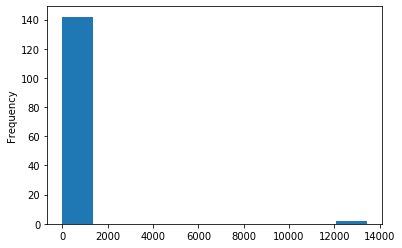

In [26]:
df_post[df_post['country']=='United Kingdom'].price.plot(kind='hist')

대부분이 2000파운드가 안 넘으면 12000파운드가 넘는 경우가 일부 있는 것으로 보인다. 데이터를 더 살펴보자. 다른 것보다 13435.5375에 의해 평균값이 많이 뛴 것으로 보인다.
무게에 따라서 금액이 다르겠으나 `customer_id`가 16029, 17450인 경우 관리자인지 한 번 검증해볼 필요가 있다.

In [27]:
df_post[(df_post['country']=='United Kingdom')&(df_post['price']>100)].head(100)

order_id product_id description  quantity          order_date  \
228189   518052       POST     POSTAGE         1 2010-08-04 11:38:00   
228190  C518053       POST     POSTAGE        -1 2010-08-04 11:39:00   
276333  C523765       POST     POSTAGE        -1 2010-09-24 10:20:00   
488287   547941       POST     POSTAGE         1 2011-03-28 14:46:00   
516089  C551685       POST     POSTAGE        -1 2011-05-03 12:51:00   
516187   551697       POST     POSTAGE         1 2011-05-03 13:46:00   
534860  C554010       POST     POSTAGE        -1 2011-05-20 12:44:00   
563726  C557638       POST     POSTAGE        -1 2011-06-21 16:01:00   
625309  C564905       POST     POSTAGE        -1 2011-08-31 12:16:00   
625310  C564905       POST     POSTAGE        -1 2011-08-31 12:16:00   
627302  C565229       POST     POSTAGE        -1 2011-09-02 09:12:00   
659319  C568410       POST     POSTAGE        -1 2011-09-27 10:42:00   

             price  customer_id         country       total  
228189    552.5520        12748  United Kingdom    552.5520  
228190    552.5520        12748  United Kingdom   -552.5520  
276333   1228.4910        17032  United Kingdom  -1228.4910  
488287    247.5000        16692  United Kingdom    247.5000  
516089  13435.5375        16029  United Kingdom -13435.5375  
516187  13435.5375        16029  United Kingdom  13435.5375  
534860    123.7500        17940  United Kingdom   -123.7500  
563726    900.2070        17450  United Kingdom   -900.2070  
625309    144.2100        17450  United Kingdom   -144.2100  
625310    131.4720        17450  United Kingdom   -131.4720  
627302    330.0000        17450  United Kingdom   -330.0000  
659319    132.0000        12748  United Kingdom   -132.0000

##### **Q. D는 무엇을 의미할까?**

In [28]:
# D
df_d = df[df['product_id']=='D']
print('product_id가 D인 데이터의 개수:', len(df_d))
df_d.head()

product_id가 D인 데이터의 개수: 169


order_id product_id description  quantity          order_date    price  \
716    C489535          D    Discount        -1 2009-12-01 12:11:00  14.8500   
717    C489535          D    Discount        -1 2009-12-01 12:11:00  31.3500   
18242  C491428          D    Discount        -1 2009-12-10 20:23:00  15.0150   
23310  C491962          D    Discount        -1 2009-12-14 16:38:00   0.9735   
28303  C492693          D    Discount        -1 2009-12-17 18:47:00  11.3025   

       customer_id         country    total  
716          15299  United Kingdom -14.8500  
717          15299  United Kingdom -31.3500  
18242        15494  United Kingdom -15.0150  
23310        13206  United Kingdom  -0.9735  
28303        13408  United Kingdom -11.3025

D는 할인을 의미하는 것으로 보인다. `quantity`가 -1인 것으로 보아 할인금액이므로 `total`은 모두 음수라고 추측된다. 한 번 확인해보자.

In [29]:
print('D인 데이터의 quantity:\n', list(df_d.quantity.unique()))

D인 데이터의 quantity:
 [-1, -30, -150, -190, -12, -18, 1, -120, -192, 192, -324, -250, -156, -128, -720, -240, -48, -96]


대부분 음수값임을 볼 수 있으며, 1인 경우는 특수한 경우로 보인다.
잘못된 값으로 봐야할지 아니면 특수한 값으로 봐야할지 고민을 해야할 듯.

In [30]:
df_d[df_d.quantity==1].head()

order_id product_id description  quantity          order_date  \
120595   504700          D    Discount         1 2010-04-15 18:08:00   
162363   509979          D    Discount         1 2010-05-26 14:07:00   
389313   535657          D    Discount         1 2010-11-28 11:20:00   
394614   536158          D    Discount         1 2010-11-30 11:57:00   

           price  customer_id         country     total  
120595   95.0895        17032  United Kingdom   95.0895  
162363  168.2835        12843  United Kingdom  168.2835  
389313   23.0670        14527  United Kingdom   23.0670  
394614   53.2785        13634  United Kingdom   53.2785

##### **Q. M은 무슨 의미일까?**

In [31]:
# M
df_m = df[df['product_id']=='M']
print('product_id가 M인 데이터의 개수:', len(df_m))
df_m.head(1000)

product_id가 M인 데이터의 개수: 1071


5.1450  
468324     21.0375        14543        United Kingdom    -21.0375  
469361     75.1905        12754                 Japan    -75.1905  
470054     74.2500        15291        United Kingdom     74.2500  
470065     26.4825        12754                 Japan    -26.4825  
470066     28.9575        12755                 Japan    -28.9575  
470142      2.0625        15834        United Kingdom      4.1250  
471031      3.4650        15023        United Kingdom     20.7900  
471577     13.1175        12924        United Kingdom     13.1175  
472229      1.6500        16771        United Kingdom     19.8000  
473531   2783.8305        14911                  EIRE  -2783.8305  
473537   2783.8305        14911                  EIRE  -2783.8305  
473538   2783.8305        14911                  EIRE   2783.8305  
473539   2783.8305        14911                  EIRE   2783.8305  
473693     16.5000        17194        United Kingdom     16.5000  
474191      0.6930        17315        United Kingdom     16.6320  
474442      3.3000        13708        United Kingdom      3.3000  
475594      1.4025        17841        United Kingdom      1.4025  
476918      0.6930        12849        United Kingdom      8.3160  
476919      3.4650        12849        United Kingdom     20.7900  
477959      8.9925        17603        United Kingdom   -917.2350  
478071      4.1250        14462        United Kingdom      8.2500  
478083      4.1250        14462        United Kingdom     -8.2500  
478178      1.5015        16422        United Kingdom   -144.1440  
478296      0.7425        15061        United Kingdom    -35.6400  
478298      1.1055        16422        United Kingdom    -27.6375  
478755      0.8250        16511        United Kingdom      3.3000  
479772     11.4675        16444        United Kingdom    -11.4675  
487046     24.6675        13240        United Kingdom     24.6675  
487734      0.8250        14410        United Kingdom      1.6500  
490294      2.7225        16788        United Kingdom      2.7225  
491193      9.4050        16422        United Kingdom     -9.4050  
491194     13.0020        16422        United Kingdom    -13.0020  
491195      0.3630        16422        United Kingdom     -0.3630  
491196     95.0400        16422        United Kingdom    -95.0400  
491197     95.0400        16422        United Kingdom    -95.0400  
491280      0.8250        14527        United Kingdom      1.6500  
491326     21.0375        14543        United Kingdom    -21.0375  
491329     18.0675        14543        United Kingdom    -36.1350  
491907      6.1875        14525        United Kingdom    -74.2500  
492185     21.0375        14543        United Kingdom     21.0375  
492186     18.0675        14543        United Kingdom     36.1350  
492479      1.0725        16960        United Kingdom      3.2175  
492563      1.6500        13184        United Kingdom      1.6500  
494532    268.2900        12744             Singapore    268.2900  
494533   3931.8180        12744             Singapore   3931.8180  
494534    394.8450        12744             Singapore    394.8450  
494535   2067.3675        12744             Singapore   2067.3675  
494536   3387.5655        12744             Singapore   3387.5655  
494537    268.2900        12744             Singapore   -268.2900  
494538   3931.8180        12744             Singapore  -3931.8180  
494539    394.8450        12744             Singapore   -394.8450  
494540   2067.3675        12744             Singapore  -2067.3675  
494541   3387.5655        12744             Singapore  -3387.5655  
494655      3.3000        13263        United Kingdom      3.3000  
495074   1874.8950        12669                France   1874.8950  
495075   1874.8950        12669                France  -1874.8950  
497242      1.4025        15005        United Kingdom      2.8050  
499035   3081.9690        17940        United Kingdom   3081.9690  
501082      2.4750        15867        United K

In [32]:
df_m.describe(include='all')

order_id product_id description     quantity           order_date  \
count      1071       1071        1071  1071.000000                 1071   
unique      973          1           1          NaN                  967   
top     C514024          M      Manual          NaN  2010-06-30 11:22:00   
freq          9       1071        1071          NaN                    9   
first       NaN        NaN         NaN          NaN  2009-12-01 16:48:00   
last        NaN        NaN         NaN          NaN  2011-11-30 14:17:00   
mean        NaN        NaN         NaN     3.071895                  NaN   
std         NaN        NaN         NaN    86.115514                  NaN   
min         NaN        NaN         NaN -1350.000000                  NaN   
25%         NaN        NaN         NaN    -1.000000                  NaN   
50%         NaN        NaN         NaN     1.000000                  NaN   
75%         NaN        NaN         NaN     2.000000                  NaN   
max         NaN        NaN         NaN  1600.000000                  NaN   

               price   customer_id         country         total  
count    1071.000000   1071.000000            1071   1071.000000  
unique           NaN           NaN              23           NaN  
top              NaN           NaN  United Kingdom           NaN  
freq             NaN           NaN             893           NaN  
first            NaN           NaN             NaN           NaN  
last             NaN           NaN             NaN           NaN  
mean      732.811434  15235.350140             NaN   -286.144756  
std      3058.573489   1764.857979             NaN   3154.123049  
min         0.000000  12346.000000             NaN -64300.500000  
25%         1.650000  13653.500000             NaN    -40.095000  
50%         8.250000  15202.000000             NaN      2.722500  
75%       344.000250  16744.000000             NaN     16.689750  
max     64300.500000  18283.000000             NaN  18073.275000

Manual은 일반 주문금액과 크게 달라보이지는 않는다. 일반 주문이 아닌 대량 주문이 아닐까 추측을 해본다. 한 번 quantity가 0보다 큰 값만 추출하여 맞는지 확인해보자.

In [33]:
print('df_m 중 quantity가 0보다 큰 경우:\n', sorted(df_m[df_m.quantity > 0].quantity.unique()))

df_m 중 quantity가 0보다 큰 경우:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 17, 18, 20, 24, 25, 28, 29, 30, 31, 34, 36, 41, 42, 48, 50, 60, 67, 72, 76, 85, 96, 144, 183, 288, 456, 832, 1200, 1600]


확인 결과 그러지 않은 것으로 보인다. 다만 대량 주문 건이 어느 정도 있는 것으로 보인다.

##### **Q. C2는 무엇을 의미할까?**

In [34]:
# C2
df_c2 = df[df['product_id']=='C2']
print('product_id가 C2인 데이터의 개수:', len(df_c2))
df_c2.head()

product_id가 C2인 데이터의 개수: 251


order_id product_id description  quantity          order_date  price  \
6725    490127         C2    CARRIAGE         1 2009-12-03 18:13:00   82.5   
11234   490542         C2    CARRIAGE         1 2009-12-07 09:42:00   82.5   
14710   490998         C2    CARRIAGE         1 2009-12-08 17:24:00   82.5   
16426   491160         C2    CARRIAGE         1 2009-12-10 10:29:00   82.5   
24226   492092         C2    CARRIAGE         1 2009-12-15 14:03:00   82.5   

       customer_id         country  total  
6725         14156            EIRE   82.5  
11234        14911            EIRE   82.5  
14710        16253  United Kingdom   82.5  
16426        14911            EIRE   82.5  
24226        14156            EIRE   82.5

In [35]:
print('df_c2의 price:', list(df_c2.price.unique()))
print('df_c2의 country:', list(df_c2.country.unique()))
print('df_c2의 customer_id:', list(df_c2.customer_id.unique()))

df_c2의 price: [82.5, 165.0, 181.5, 41.25, 247.5, 29.7]
df_c2의 country: ['EIRE', 'United Kingdom', 'France', 'Channel Islands']
df_c2의 customer_id: [14156, 14911, 16253, 18286, 15064, 14016, 18285, 13377, 14817, 14944, 16256, 13338, 12737, 12678, 13360, 13374, 14934, 13367, 18284, 13368, 16265, 13359, 13996, 14932, 14756, 18287, 13369, 13345, 13908, 13358, 14931, 13376, 14565, 12493, 13343, 16257, 13372, 13350, 16268, 13347, 13351, 13352, 13363, 12749, 13349]


POST와 C2의 차이점은 `price`이다. C2는 POST에 비해 정해진 가격이 있다. 개인적인 생각으로는 Carriage는 일일특급과 같은 비싼 운송 서비스로 생각되며, POST는 택배라고 생각이 된다.

C2의 나라를 보면 영국을 제외하고 영국과 가까운 나라임을 볼 수 있다.

##### **Q. PADS는 무엇을 의미할까?**

In [36]:
# PADS
df_pads = df[df['product_id']=='PADS']
print('product_id가 PADS인 데이터의 개수:', len(df_pads))
df_pads.head(19)

product_id가 PADS인 데이터의 개수: 19


order_id product_id                 description  quantity  \
42295    494914       PADS  PADS TO MATCH ALL CUSHIONS         1   
51781    496222       PADS  PADS TO MATCH ALL CUSHIONS         1   
54235    496473       PADS  PADS TO MATCH ALL CUSHIONS         1   
55662    496643       PADS  PADS TO MATCH ALL CUSHIONS         1   
64399    497935       PADS  PADS TO MATCH ALL CUSHIONS         1   
69706    498562       PADS  PADS TO MATCH ALL CUSHIONS         1   
73322    499056       PADS  PADS TO MATCH ALL CUSHIONS         1   
75523    499399       PADS  PADS TO MATCH ALL CUSHIONS         1   
90549    501176       PADS  PADS TO MATCH ALL CUSHIONS         1   
117083   504332       PADS  PADS TO MATCH ALL CUSHIONS         1   
134644   506303       PADS  PADS TO MATCH ALL CUSHIONS         1   
191296  C513477       PADS  PADS TO MATCH ALL CUSHIONS        -1   
266320   522766       PADS  PADS TO MATCH ALL CUSHIONS         1   
348813   531433       PADS  PADS TO MATCH ALL CUSHIONS         1   
369521   533528       PADS  PADS TO MATCH ALL CUSHIONS         1   
505013   550193       PADS  PADS TO MATCH ALL CUSHIONS         1   
593324   561226       PADS  PADS TO MATCH ALL CUSHIONS         1   
656006   568158       PADS  PADS TO MATCH ALL CUSHIONS         1   
657180   568200       PADS  PADS TO MATCH ALL CUSHIONS         1   

                order_date     price  customer_id         country     total  
42295  2010-01-19 17:04:00   0.00165        16705  United Kingdom   0.00165  
51781  2010-01-29 13:53:00   0.00165        13583  United Kingdom   0.00165  
54235  2010-02-01 15:38:00   0.00165        17350  United Kingdom   0.00165  
55662  2010-02-03 11:58:00   0.00165        13408  United Kingdom   0.00165  
64399  2010-02-15 10:47:00   0.00165        13408  United Kingdom   0.00165  
69706  2010-02-21 12:03:00   0.00165        15182  United Kingdom   0.00165  
73322  2010-02-24 13:46:00   0.00165        13765  United Kingdom   0.00165  
75523  2010-02-26 13:26:00   0.00165        14459  United Kingdom   0.00165  
90549  2010-03-15 11:00:00   0.00165        14857  United Kingdom   0.00165  
117083 2010-04-12 16:30:00   0.00165        12671         Germany   0.00165  
134644 2010-04-29 10:43:00   0.00165        14249  United Kingdom   0.00165  
191296 2010-06-24 16:56:00  60.39000        14459  United Kingdom -60.39000  
266320 2010-09-16 13:58:00   0.00165        15182  United Kingdom   0.00165  
348813 2010-11-08 11:54:00   0.00165        13317  United Kingdom   0.00165  
369521 2010-11-17 15:08:00   0.00165        15750  United Kingdom   0.00165  
505013 2011-04-15 09:27:00   0.00165        13952  United Kingdom   0.00165  
593324 2011-07-26 10:13:00   0.00165        15618  United Kingdom   0.00165  
656006 2011-09-25 12:22:00   0.00000        16133  United Kingdom   0.00000  
657180 2011-09-25 14:58:00   0.00165        16198  United Kingdom   0.00165

In [37]:
print('df_pads의 price:', list(df_pads.price.unique()))
print('df_pads의 quantity:', list(df_pads.quantity.unique()))
print('df_pads의 country:', list(df_pads.country.unique()))

df_pads의 price: [0.00165, 60.39, 0.0]
df_pads의 quantity: [1, -1]
df_pads의 country: ['United Kingdom', 'Germany']


쿠션에 넣는 추가 물품으로 추측이 된다. 한번 특정 `order_id`를 뽑아서 공통된 아이템이 있는지 살펴보자.

In [38]:
orders = list(df_pads.order_id)    # PADS가 있는 데이터의 주문ID
products = set()                      # 상품 리스트
for order in orders:
    p_list = set(df[df.order_id == order].description)
    if not products:
        products.update(p_list)
    else:
        products.intersection(p_list)
print('PADS를 갖는 주문의 공통 주문 상품:\n', '\n'.join(list(products)))

PADS를 갖는 주문의 공통 주문 상품:
 VINTAGE CARAVAN GIFT WRAP
BIRD DECORATION RED SPOT
KINGS CHOICE BISCUIT TIN
EASTER CRAFT 4 CHICKS 
LUNCHBOX WITH CUTLERY RETROSPOT 
COFFEE MUG PINK PAISLEY DESIGN
EASTER TIN BUCKET
EASTER CRAFT IVY WREATH WITH CHICK
BIRD DECORATION GREEN  SPOT
VINTAGE HEADS AND TAILS CARD GAME 
SET/5 RED SPOTTY LID GLASS BOWLS
SPACEBOY GIFT WRAP
GIN & TONIC DIET GREETING CARD 
VINTAGE SNAP CARDS
DOORMAT AIRMAIL 
KINGS CHOICE TEA CADDY 
PADS TO MATCH ALL CUSHIONS
TEA PARTY  WRAPPING PAPER 
SPACEBOY BIRTHDAY CARD
BOYS VINTAGE TIN SEASIDE BUCKET


공통된 상품은 위와 같다. 하지만 PADS의 사용용도는 잘 모르겠다.

##### **Q. DOT는 무엇을 의미할까?**

In [39]:
# DOT
df_dot = df[df['product_id']=='DOT']
print('product_id가 DOT인 데이터의 개수:', len(df_dot))
df_dot.head()

product_id가 DOT인 데이터의 개수: 15


order_id product_id     description  quantity          order_date  \
624749   564764        DOT  DOTCOM POSTAGE         1 2011-08-30 10:49:00   
628147   565383        DOT  DOTCOM POSTAGE         1 2011-09-02 15:45:00   
635761   566217        DOT  DOTCOM POSTAGE         1 2011-09-09 15:17:00   
640298   566566        DOT  DOTCOM POSTAGE         1 2011-09-13 12:32:00   
650253   567656        DOT  DOTCOM POSTAGE         1 2011-09-21 14:40:00   

            price  customer_id         country      total  
624749    18.4305        14096  United Kingdom    18.4305  
628147    27.1590        14096  United Kingdom    27.1590  
635761    21.7140        14096  United Kingdom    21.7140  
640298   141.2070        14096  United Kingdom   141.2070  
650253  1449.6075        14096  United Kingdom  1449.6075

DOTCOM과 관련해서 검색해본 결과 [DOTCOM DISTRIBUTION](https://dotcomdist.com/)이라는 회사가 있음을 볼 수 있다. 위키백과에 따르면 쿠팡같은 e-commerce기업으로 보인다. 그래서 그런지 `country`는 영국 밖에 없으며, `customer_id`는 14096 밖에 없다.

In [40]:
print('df_dot의 price:', list(df_dot.price.unique()))
print('df_dot의 quantity:', list(df_dot.quantity.unique()))
print('df_dot의 country:', list(df_dot.country.unique()))
print('df_dot의 customer_id:', list(df_dot.customer_id.unique()))
print('df_dot의 description:', list(df_dot.description.unique()))

df_dot의 price: [18.4305, 27.159000000000002, 21.714000000000002, 141.207, 1449.6074999999996, 1135.3319999999999, 808.9124999999998, 1047.7665, 1226.973, 1053.195, 1487.6070000000002, 1498.464, 2475.594, 2095.599, 2519.154]
df_dot의 quantity: [1]
df_dot의 country: ['United Kingdom']
df_dot의 customer_id: [14096]
df_dot의 description: ['DOTCOM POSTAGE']


##### **Q. CRUK는 무엇을 의미할까?**

이것도 검색해본 결과 [Cancer Rearch UK](https://www.cancerresearchuk.org/)로 자선단체임을 알 수 있다.

In [41]:
# CRUK
df_cruk = df[df['product_id']=='CRUK']
print('product_id가 CRUK인 데이터의 개수:', len(df_cruk))
df_cruk.head()

product_id가 CRUK인 데이터의 개수: 15


order_id product_id      description  quantity          order_date  \
624750  C564763       CRUK  CRUK Commission        -1 2011-08-30 10:49:00   
628148  C565382       CRUK  CRUK Commission        -1 2011-09-02 15:45:00   
635750  C566216       CRUK  CRUK Commission        -1 2011-09-09 15:17:00   
640280  C566565       CRUK  CRUK Commission        -1 2011-09-13 12:32:00   
650235  C567655       CRUK  CRUK Commission        -1 2011-09-21 14:40:00   

            price  customer_id         country      total  
624750     2.6400        14096  United Kingdom    -2.6400  
628148    21.4665        14096  United Kingdom   -21.4665  
635750    26.3340        14096  United Kingdom   -26.3340  
640280    86.1960        14096  United Kingdom   -86.1960  
650235  1004.2890        14096  United Kingdom -1004.2890

In [42]:
print('df_cruk의 price:', list(df_cruk.price.unique()))
print('df_cruk의 quantity:', list(df_cruk.quantity.unique()))
print('df_cruk의 country:', list(df_cruk.country.unique()))
print('df_cruk의 customer_id:', list(df_cruk.customer_id.unique()))
print('df_cruk의 order_id:', list(df_cruk.order_id.unique()))
print('df_cruk의 description:', list(df_cruk.description.unique()))

df_cruk의 price: [2.64, 21.4665, 26.334, 86.196, 1004.289, 738.4739999999998, 596.6234999999998, 679.668, 818.367, 701.4810000000001, 999.9, 853.8915, 1713.9375, 1402.3845, 1628.781]
df_cruk의 quantity: [-1]
df_cruk의 country: ['United Kingdom']
df_cruk의 customer_id: [14096]
df_cruk의 order_id: ['C564763', 'C565382', 'C566216', 'C566565', 'C567655', 'C568345', 'C569245', 'C570487', 'C571440', 'C572551', 'C573575', 'C575606', 'C576338', 'C578269', 'C579195']
df_cruk의 description: ['CRUK Commission']


위의 결과로 다음을 알 수 있다.
- 자선단체이기 때문에 모든 수량이 -1이며, 환불하는 것처럼 로그에 입력된다.
- `description`, `country`, `customer_id` 모두 CRUK Commission, 영국, 14096으로 동일하다.
- DOTCOM에서 구매해서 CRUK에 기부를 한다.

##### **Q. BANK CHARGES는 무엇을 의미할까?**

In [43]:
# BANK CHARGES
df_bank = df[df['product_id']=='BANK CHARGES']
print('product_id가 BANK CHARGES인 데이터의 개수:', len(df_bank))
df_bank.head()

product_id가 BANK CHARGES인 데이터의 개수: 36


order_id    product_id    description  quantity          order_date  \
14036   C490943  BANK CHARGES   Bank Charges        -1 2009-12-08 14:08:00   
14092    490948  BANK CHARGES   Bank Charges         1 2009-12-08 14:29:00   
67386    498269  BANK CHARGES   Bank Charges         1 2010-02-17 15:03:00   
109974   503497  BANK CHARGES   Bank Charges         1 2010-04-01 12:07:00   
110685  C503571  BANK CHARGES   Bank Charges        -1 2010-04-01 15:45:00   

        price  customer_id         country  total  
14036   24.75        16703  United Kingdom -24.75  
14092   24.75        16805  United Kingdom  24.75  
67386   24.75        16928  United Kingdom  24.75  
109974  24.75        17539  United Kingdom  24.75  
110685  24.75        17539  United Kingdom -24.75

In [44]:
print('df_bank의 price:', list(df_bank.price.unique()))
print('df_bank의 quantity:', list(df_bank.quantity.unique()))
print('df_bank의 country:', list(df_bank.country.unique()))
print('df_bank의 customer_id:', list(df_bank.customer_id.unique()))
print('df_bank의 order_id:', list(df_bank.order_id.unique()))
print('df_bank의 description:', list(df_bank.description.unique()))

df_bank의 price: [24.75, 74.25, 0.00165]
df_bank의 quantity: [-1, 1]
df_bank의 country: ['United Kingdom', 'EIRE']
df_bank의 customer_id: [16703, 16805, 16928, 17539, 12843, 17448, 17032, 14085, 14606, 14911, 16271, 16879, 13776, 13174, 15823, 15939, 16714, 16904, 13405, 13263, 14704, 13651]
df_bank의 order_id: ['C490943', '490948', '498269', '503497', 'C503571', '503960', '505204', '509375', '509669', '511774', '512658', '515845', '515855', '517648', '517652', '518666', '518667', '521809', '521812', 'C522928', 'C524124', 'C525876', 'C525914', '532637', '535474', '536779', '541505', '549717', '551945', '565735', '568375', '571900', '573586', '574546', '579137']
df_bank의 description: [' Bank Charges', 'Bank Charges']


위의 결과로 다음을 알 수 있다.
- BANK CHARGES는 은행 수수료로 보인다.
- 24.75, 74.25(1개), 0.00165(1개)로 가격이 고정되어 이는 것을 볼 수 있다.
- BANK CHARGES가 된 나라는 아일랜드랑 영국밖에 없다.
- `description`에 띄어쓰기가 살짝 잘못된 것이 있다.

##### **Q. TEST001, TEST002는 무엇을 의미할까?**

In [45]:
# TEST
df_test = df[df['product_id'].str.contains('TEST')]
print('product_id가 TEST인 데이터의 개수:', len(df_test))
df_test.head(16)

product_id가 TEST인 데이터의 개수: 16


order_id product_id              description  quantity  \
21447    491725    TEST001  This is a test product.        10   
21702    491742    TEST001  This is a test product.         5   
21705    491744    TEST001  This is a test product.         5   
28492    492718    TEST001  This is a test product.         5   
28504    492722    TEST002  This is a test product.         1   
31276    493410    TEST001  This is a test product.         5   
31278    493412    TEST001  This is a test product.         5   
37892    494450    TEST001  This is a test product.         5   
44909    495295    TEST001  This is a test product.         5   
62932    497819    TEST001  This is a test product.         5   
63021    497843    TEST001  This is a test product.         5   
116368   504188    TEST001  This is a test product.         5   
291614  C525272    TEST001  This is a test product.        -1   
291615  C525273    TEST001  This is a test product.        -1   
291616  C525274    TEST001  This is a test product.        -1   
291617  C525275    TEST001  This is a test product.        -2   

                order_date  price  customer_id         country   total  
21447  2009-12-14 08:34:00  7.425        12346  United Kingdom  74.250  
21702  2009-12-14 11:00:00  7.425        12346  United Kingdom  37.125  
21705  2009-12-14 11:02:00  7.425        12346  United Kingdom  37.125  
28492  2009-12-18 10:47:00  7.425        12346  United Kingdom  37.125  
28504  2009-12-18 10:55:00  1.650        12346  United Kingdom   1.650  
31276  2010-01-04 09:24:00  7.425        12346  United Kingdom  37.125  
31278  2010-01-04 09:53:00  7.425        12346  United Kingdom  37.125  
37892  2010-01-14 13:50:00  7.425        12346  United Kingdom  37.125  
44909  2010-01-22 13:30:00  7.425        12346  United Kingdom  37.125  
62932  2010-02-12 14:58:00  0.000        14103  United Kingdom   0.000  
63021  2010-02-12 15:47:00  0.000        14827  United Kingdom   0.000  
116368 2010-04-12 09:52:00  7.425        16454  United Kingdom  37.125  
291614 2010-10-04 16:29:00  7.425        16454  United Kingdom  -7.425  
291615 2010-10-04 16:30:00  7.425        16454  United Kingdom  -7.425  
291616 2010-10-04 16:33:00  7.425        12346  United Kingdom  -7.425  
291617 2010-10-04 16:38:00  7.425        16446  United Kingdom -14.850

- 관리자가 시스템 테스트를 위해 임의로 넣은 데이터로 보인다.
- `customer_id`가 12346, 14103, 14827, 16454, 16446이다. (관리자로 생각되며 각 고객의 로그는 찾아볼 필요가 있다.)
- 시스템 테스트 날짜는 2009년 12월 14일, 2009년 12월 18일, 2010년 1월 4일, 2010년 1월 14일, 2010년 1월 22일, 2010년 2월 12일, 2010년 4월 12일, 2010년 10월 4일로 확인된다.

##### **Q. ADJUST, ADJUST2는 무엇을 의미할까?**

In [46]:
# ADJUST
df_adj = df[df['product_id'].str.contains('ADJUST')]
print('product_id가 ADJUST인 데이터의 개수:', len(df_adj))
df_adj.tail(10)

product_id가 ADJUST인 데이터의 개수: 64


order_id product_id                          description  quantity  \
49054    495799     ADJUST  Adjustment by john on 26/01/2010 17         1   
49055   C495800     ADJUST  Adjustment by john on 26/01/2010 17        -1   
49056    495801     ADJUST  Adjustment by john on 26/01/2010 17         1   
49057    495802     ADJUST  Adjustment by john on 26/01/2010 17         1   
159489  C509473     ADJUST  Adjustment by Peter on 24/05/2010 1        -1   
159490  C509474     ADJUST  Adjustment by Peter on 24/05/2010 1        -1   
159491  C509475     ADJUST  Adjustment by Peter on 24/05/2010 1        -1   
191910   513564    ADJUST2  Adjustment by Peter on Jun 25 2010          1   
191911   513566    ADJUST2  Adjustment by Peter on Jun 25 2010          1   
191912   513565    ADJUST2  Adjustment by Peter on Jun 25 2010          1   

                order_date     price  customer_id         country     total  
49054  2010-01-26 17:26:00  134.6565        13327  United Kingdom  134.6565  
49055  2010-01-26 17:27:00  170.7750        12346  United Kingdom -170.7750  
49056  2010-01-26 17:28:00  127.9080        12570           Spain  127.9080  
49057  2010-01-26 17:28:00  639.4410        12748  United Kingdom  639.4410  
159489 2010-05-24 11:12:00  495.2145        17050  United Kingdom -495.2145  
159490 2010-05-24 11:13:00  119.5425        16422  United Kingdom -119.5425  
159491 2010-05-24 11:13:00  591.4755        17364  United Kingdom -591.4755  
191910 2010-06-25 14:15:00  495.2145        17050  United Kingdom  495.2145  
191911 2010-06-25 14:15:00  591.4755        17364  United Kingdom  591.4755  
191912 2010-06-25 14:15:00  119.5425        16422  United Kingdom  119.5425

In [47]:
print('df_adj의 quantity:', list(df_adj.quantity.unique()))
print('df_adj의 country:', list(df_adj.country.unique()))
print('df_adj의 customer_id:', list(df_adj.customer_id.unique()))
print('df_adj의 description:', list(df_adj.description.unique()))

df_adj의 quantity: [1, -1]
df_adj의 country: ['EIRE', 'United Kingdom', 'Spain', 'Finland', 'Netherlands', 'France', 'Portugal', 'Italy', 'Germany', 'Unspecified', 'Nigeria']
df_adj의 customer_id: [14911, 12745, 16154, 12606, 13054, 12454, 15383, 12706, 12404, 16840, 12382, 12466, 16291, 12555, 14156, 12858, 14912, 14413, 14653, 12846, 16575, 12647, 13664, 14285, 16047, 12792, 12709, 12696, 17130, 15357, 13776, 12600, 17940, 15266, 17867, 16168, 14380, 13468, 13136, 14079, 17672, 12497, 12471, 15702, 14358, 12826, 13327, 12346, 12570, 12748, 17050, 16422, 17364]
df_adj의 description: ['Adjustment by john on 26/01/2010 16', 'Adjustment by john on 26/01/2010 17', 'Adjustment by Peter on 24/05/2010 1', 'Adjustment by Peter on Jun 25 2010 ']


- 지역은 다양하다. Unspecified도 포함이 되어 있다.
- 특정 customer_id에만 반응하는 것은 아닌 것으로 보인다.
- john, peter에 의해 조정되었다고 적혀있다. -> 고객의 거래 내역을 확인해볼 필요가 있다.
    - ADJUST만 있는 경우도 있고 거래 내역이 여러 개 있는 경우도 존재한다.

In [48]:
start = datetime.datetime(2010, 10, 4, 15, 40, 0)
end = datetime.datetime(2010, 10, 4, 16, 40, 0)
df[df.order_date.between(start, end)].head(100)

order_id product_id                          description  quantity  \
291555   525260      22727            ALARM CLOCK BAKELIKE RED          4   
291556   525260      22740                         POLKADOT PEN        48   
291557   525260      22866        HAND WARMER SCOTTY DOG DESIGN        12   
291558   525260      21259          VICTORIAN SEWING BOX SMALL          2   
291559   525260      22149           FELTCRAFT 6 FLOWER FRIENDS        12   
291560   525260      20685                DOORMAT RED RETROSPOT         2   
291561   525260      22366                     DOORMAT AIRMAIL          2   
291562   525260      22139     RETROSPOT TEA SET CERAMIC 11 PC          3   
291563   525260      20750             RED RETROSPOT MINI CASES         2   
291564   525260     47594B              SCOTTIES DESIGN WASHBAG        12   
291565   525260      22276        WASH BAG VINTAGE ROSE PAISLEY         6   
291566   525260      21112        SWISS ROLL TOWEL, PINK  SPOTS         6   
291567   525260      21524       DOORMAT SPOTTY HOME SWEET HOME         2   
291568   525260     48173C                 DOORMAT BLACK FLOCK          2   
291569   525261      22086      PAPER CHAIN KIT 50'S CHRISTMAS         40   
291570   525261      20967   GREY FLORAL FELTCRAFT SHOULDER BAG         4   
291571   525261      20970   PINK FLORAL FELTCRAFT SHOULDER BAG         4   
291572   525261      22083           PAPER CHAIN KIT RETRO SPOT        12   
291573   525261      22147           FELTCRAFT BUTTERFLY HEARTS        12   
291574   525261      21967             PACK OF 12 SKULL TISSUES        48   
291575   525261      20971     PINK BLUE FELT CRAFT TRINKET BOX        24   
291576   525261      20972   PINK CREAM FELT CRAFT TRINKET BOX         24   
291577   525261      22149           FELTCRAFT 6 FLOWER FRIENDS         6   
291578   525261      22274                 FELTCRAFT DOLL EMILY         6   
291579   525261      22749    FELTCRAFT PRINCESS CHARLOTTE DOLL        12   
291580   525261      22084               PAPER CHAIN KIT EMPIRE         6   
291581   525261      22940            FELTCRAFT CHRISTMAS FAIRY        12   
291582   525261      84992       72 SWEETHEART FAIRY CAKE CASES        24   
291583   525261      21213          PACK OF 72 SKULL CAKE CASES        48   
291584   525260      20972   PINK CREAM FELT CRAFT TRINKET BOX         12   
291585   525260      22271                 FELTCRAFT DOLL ROSIE         6   
291586   525260      22568                FELTCRAFT CUSHION OWL         4   
291587   525260      21181         PLEASE ONE PERSON METAL SIGN        12   
291588   525260      22138        BAKING SET 9 PIECE RETROSPOT          3   
291589   525260      22179              SET 10 LIGHTS NIGHT OWL         2   
291590   525260      21930             JUMBO STORAGE BAG SKULLS        20   
291591   525260      21929       JUMBO BAG PINK VINTAGE PAISLEY        10   
291592   525260      20711                      JUMBO BAG TOYS         10   
291593   525263      22083            PAPER CHAIN KIT RETROSPOT        18   
291594   525263      22333    RETROSPOT PARTY BAG + STICKER SET        24   
291595   525263      21172                    PARTY METAL SIGN         12   
291596   525263      21244                 BLUE POLKADOT PLATE          8   
291597   525263      22130     PARTY CONE CHRISTMAS DECORATION         12   
291598   525263      20914  SET/5 RED RETROSPOT LID GLASS BOWLS         6   
291599   525263      21240                    BLUE POLKADOT CUP         8   
291600   525263      22090              PAPER BUNTING RETROSPOT        30   
291601   525263     47599A                      PINK PARTY BAGS        30   
291602   525262      22098            BOUDOIR SQUARE TISSUE BOX        36   
291603   525262      22184  CAKE STAND VICTORIAN FILIGREE LARGE         8   
291604   525262     85018D      YULETIDE IMAGES S/6 PAPER BOXES        24   
291605   525262      22133            PINK LOVE HEART SHAPE CUP        12   
291

위에 표시된 날짜의 거래내역을 살펴보았지만 특이사항은 없어보인다.

##### **Q. SP1002는 무엇을 의미할까?**

In [49]:
# SP1002
df_sp = df[df['product_id']=='SP1002']
print('product_id가 SP1002인 데이터의 개수:', len(df_sp))
df_sp.head()

product_id가 SP1002인 데이터의 개수: 2


order_id product_id             description  quantity  \
295890   525772     SP1002  KID'S CHALKBOARD/EASEL         1   
296211   525837     SP1002  KID'S CHALKBOARD/EASEL         4   

                order_date   price  customer_id         country    total  
295890 2010-10-07 11:12:00  4.8675        12748  United Kingdom   4.8675  
296211 2010-10-07 12:23:00  4.8675        17841  United Kingdom  19.4700

다른 상품들과 달리 SP1002로 찍힌 것 외에는 별다른 차이점이 없어보인다. 특가상품이었던 것 같다.

### 3.2. Customer ID

위에서 언급된 사용자 ID 목록
- DOTCOM, CRUK: 14096
- TEST: 12346, 14103, 14827, 16454, 16466

##### Q. `customer_id`가 12346인 고객은 쇼핑몰 관리자로 보인다. 이 관리자의 `total`은 어떠할까?

In [50]:
manager = df[df.customer_id == 12346]
print('관리자 데이터의 개수:', len(manager))
print('관리자 데이터의 product_id:\n', manager.product_id.unique())

관리자 데이터의 개수: 47
관리자 데이터의 product_id:
 ['TEST001' 'TEST002' 'ADJUST' '20682' '20679' '15056N' '15056BL' '15056P'
 '21524' '22692' '22660' '22687' '48173C' '22691' '48111' '22690' '21523'
 '48138' '22689' '22365' '48185' '22688' '48188' '48187' '22366' '20685'
 '21955' 'M' 'D' '23166']


- 관리자 데이터는 47개로 그렇게 많은 것으로 보이지는 않는다.
- `product_id`가 이상한 경우 관리자인 것으로 볼 수 있다.

In [51]:
manager.head(47)

order_id product_id                          description  quantity  \
21447    491725    TEST001              This is a test product.        10   
21702    491742    TEST001              This is a test product.         5   
21705    491744    TEST001              This is a test product.         5   
28492    492718    TEST001              This is a test product.         5   
28504    492722    TEST002              This is a test product.         1   
31276    493410    TEST001              This is a test product.         5   
31278    493412    TEST001              This is a test product.         5   
37892    494450    TEST001              This is a test product.         5   
44909    495295    TEST001              This is a test product.         5   
49055   C495800     ADJUST  Adjustment by john on 26/01/2010 17        -1   
78388    499763      20682           RED SPOTTY CHILDS UMBRELLA         1   
78389    499763      20679                EDWARDIAN PARASOL RED         1   
78390    499763     15056N            EDWARDIAN PARASOL NATURAL         1   
78391    499763    15056BL              EDWARDIAN PARASOL BLACK         1   
78392    499763     15056P               EDWARDIAN PARASOL PINK         1   
194356   513774      21524       DOORMAT SPOTTY HOME SWEET HOME         1   
194357   513774      22692          DOORMAT WELCOME TO OUR HOME         1   
194358   513774      22660                DOORMAT I LOVE LONDON         1   
194359   513774      22687            DOORMAT CHRISTMAS VILLAGE         1   
194360   513774     48173C                 DOORMAT BLACK FLOCK          1   
194361   513774      22691              DOORMAT WELCOME SUNRISE         1   
194362   513774      48111                DOORMAT 3 SMILEY CATS         1   
194363   513774      22690        DOORMAT HOME SWEET HOME BLUE          1   
194364   513774      21523   DOORMAT FANCY FONT HOME SWEET HOME         1   
194365   513774      48138                   DOORMAT UNION FLAG         1   
194366   513774      22689         DOORMAT MERRY CHRISTMAS RED          1   
194367   513774      22365            DOORMAT RESPECTABLE HOUSE         1   
194368   513774      48185                   DOORMAT FAIRY CAKE         1   
194369   513774      22688          DOORMAT PEACE ON EARTH BLUE         1   
194370   513774      48188              DOORMAT WELCOME PUPPIES         1   
194371   513774      48187                  DOORMAT NEW ENGLAND         1   
194372   513774      22366                     DOORMAT AIRMAIL          1   
194373   513774      20685                     DOORMAT RED SPOT         1   
194374   513774      21955    DOORMAT UNION JACK GUNS AND ROSES         1   
196542  C514024          M                               Manual        -1   
196543  C514024          M                               Manual        -1   
196544  C514024          M                               Manual        -1   
196545  C514024          M                               Manual        -1   
196546  C514024          M                               Manual        -3   
196547  C514024          M                               Manual        -1   
196548  C514024          M                               Manual        -4   
196549  C514024          M                               Manual        -1   
196550  C514024          M                               Manual        -1   
290224  C525099          D                             Discount        -1   
291616  C525274    TEST001              This is a test product.        -1   
433791   541431      23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
433796  C541433      23166       MEDIUM CERAMIC TOP STORAGE JAR    -74215   

                order_date     price  customer_id         country        total  
21447  2009-12-14 08:34:00    7.4250        12346  United Kingdom      74.2500  
21702  2009-12-14 11:00:00    7.4250        12346  United Kingdom      37.1250  
21705  2009-12-14 11:02:00    7.4250        12346  United Kingdom  

- 마지막 로그인 541431을 제외하고 `total`이 300파운드가 넘지 않는 것으로 보인다. 관리자의 경우 300파운드가 넘지 않는다고 생각해도 괜찮을 것 같다.
- MANUAL, DISCOUNT,TEST 여러 개가 섞여있지만 물건의 경우 비정상적이게 모든 물건의 구매액이 동일하다.

##### **Q. 그 외에 다른 관리자 계정이 존재할까?**

우선 TEST001, TEST002에 언급된 `customer_id`는 다음과 같다.
- 12346, 14103, 14827, 16454, 16446

이 중 12346을 제외하고 한 번 살펴보자.

In [52]:
df[(df.customer_id==16446)|(df.customer_id==14103)|(df.customer_id==14827)|(df.customer_id==16454)].head(100)

order_id product_id                          description  quantity  \
55361   C496598       POST                              POSTAGE        -1   
62932    497819    TEST001              This is a test product.         5   
63021    497843    TEST001              This is a test product.         5   
112883   503830     46000M         POLYESTER FILLER PAD 45x45cm         1   
116368   504188    TEST001              This is a test product.         5   
291614  C525272    TEST001              This is a test product.        -1   
291615  C525273    TEST001              This is a test product.        -1   
291617  C525275    TEST001              This is a test product.        -2   
502533  C549930          M                               Manual        -1   
531730   553573      22980               PANTRY SCRUBBING BRUSH         1   
531731   553573      22982                  PANTRY PASTRY BRUSH         1   
676041   569915     90012A  MIDNIGHT BLUE DROP CRYSTAL NECKLACE         2   
706424   572832          M                               Manual         1   

                order_date    price  customer_id         country    total  
55361  2010-02-02 16:18:00   8.2500        16454  United Kingdom  -8.2500  
62932  2010-02-12 14:58:00   0.0000        14103  United Kingdom   0.0000  
63021  2010-02-12 15:47:00   0.0000        14827  United Kingdom   0.0000  
112883 2010-04-07 15:54:00   2.5575        16454  United Kingdom   2.5575  
116368 2010-04-12 09:52:00   7.4250        16454  United Kingdom  37.1250  
291614 2010-10-04 16:29:00   7.4250        16454  United Kingdom  -7.4250  
291615 2010-10-04 16:30:00   7.4250        16454  United Kingdom  -7.4250  
291617 2010-10-04 16:38:00   7.4250        16446  United Kingdom -14.8500  
502533 2011-04-13 10:36:00  24.8325        16454  United Kingdom -24.8325  
531730 2011-05-18 09:52:00   2.7225        16446  United Kingdom   2.7225  
531731 2011-05-18 09:52:00   2.0625        16446  United Kingdom   2.0625  
676041 2011-10-06 16:57:00   4.8675        16454  United Kingdom   9.7350  
706424 2011-10-26 11:40:00   1.6500        16454  United Kingdom   1.6500

실제로 상품을 구매한 고객도 보이고(16454, 16446) TEST용으로 일회용으로만 쓰이는 ID도 보인다.(14103, 14827)
실제 관리자 계정은 14103과 14827로 보인다.

##### **Q. 고객들의 주문 횟수는 어느정도일까?**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66599e9b10>]],
      dtype=object)

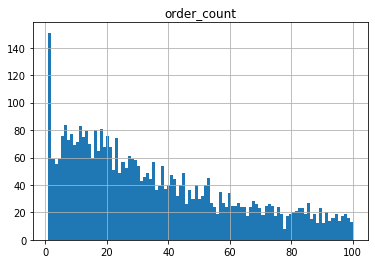

In [53]:
customer_orders = pd.DataFrame(df.groupby('customer_id')['order_id'].count().sort_values(ascending=False))
customer_orders.rename(columns={'order_id':'order_count'}, inplace=True)
customer_orders[customer_orders.order_count <= 100].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6659ccc990>]],
      dtype=object)

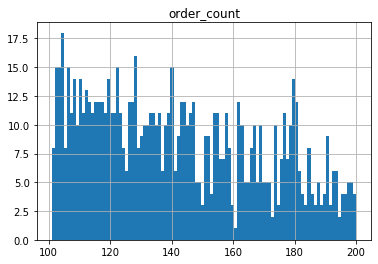

In [54]:
customer_orders[(customer_orders.order_count > 100)&(customer_orders.order_count <= 200)].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f665c00a990>]],
      dtype=object)

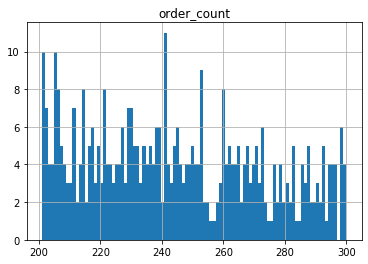

In [55]:
customer_orders[(customer_orders.order_count > 200)&(customer_orders.order_count <= 300)].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66503bd690>]],
      dtype=object)

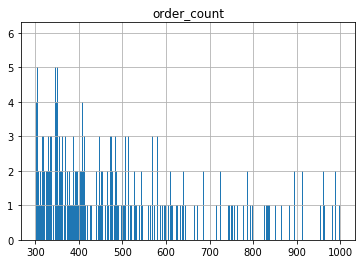

In [56]:
customer_orders[(customer_orders.order_count > 300)&(customer_orders.order_count <= 1000)].hist(bins=700)

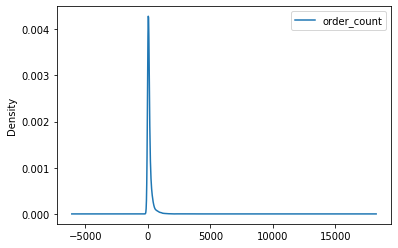

In [57]:
customer_orders[customer_orders.order_count > 1].plot(kind='kde')

- 우선 첫 구매자들이 압도적으로 많은 것으로 보인다.
- 그 외에는 재구매자들이 많으며, 20개 이상부터는 주문 수가 떨어지고 계속 급감하다가 60부터 평이하다가 100에서 200으로 가면서 주문수가 떨어지는 것을 볼 수 있다.
- 이로 미루어봤을 때, 주문횟수가 꽤 많은 영향을 끼칠 것으로 보인다. 주문 횟수와 환불 횟수를 나누어볼 필요가 있다.

### 3.3. Order ID

In [58]:
print('order_id의 개수:', len(df.order_id.unique()))
print('길이가 6인 order_id의 개수:', len(df[df.order_id.str.len()==6].order_id.unique()))
print('길이가 7인 order_id의 개수:', len(df[df.order_id.str.len()==7].order_id.unique()))
print('모두 숫자로 이루어진 order_id의 개수:', len(df[df.order_id.str.isdigit()].order_id.unique()))
print('숫자와 문자로 이루어진 order_id의 개수:', len(df[~(df.order_id.str.isdigit())].order_id.unique()))
print('알파벳 C를 포함하는 order_id의 개수:', len(df[df.order_id.str.contains('C')].order_id.unique()))

order_id의 개수: 43955
길이가 6인 order_id의 개수: 36197
길이가 7인 order_id의 개수: 7758
모두 숫자로 이루어진 order_id의 개수: 36197
숫자와 문자로 이루어진 order_id의 개수: 7758
알파벳 C를 포함하는 order_id의 개수: 7758


6자리는 모두 숫자로 이루어진 경우이고 7자리는 숫자와 문자로 이루어진 경우로 볼 수 있다. 문자로 이루어진 경우는 C를 포함하고 있다.

##### **Q. order_id에 C를 포함하고 있는 경우는 어떤 특징을 가지고 있을까?**

In [59]:
refunds = df[df.order_id.str.contains('C')]
refunds.customer_id = refunds.customer_id.astype('str')
print('refunds의 데이터 개수:', len(refunds))
refunds.describe(include='all')

refunds의 데이터 개수: 18034


order_id product_id description      quantity           order_date  \
count     18034      18034       18034  18034.000000                18034   
unique     7758       2821        2992           NaN                 7617   
top     C570867          M      Manual           NaN  2011-10-12 16:17:00   
freq        101        391         391           NaN                  101   
first       NaN        NaN         NaN           NaN  2009-12-01 10:33:00   
last        NaN        NaN         NaN           NaN  2011-11-30 17:42:00   
mean        NaN        NaN         NaN    -21.593157                  NaN   
std         NaN        NaN         NaN    576.301654                  NaN   
min         NaN        NaN         NaN -74215.000000                  NaN   
25%         NaN        NaN         NaN     -6.000000                  NaN   
50%         NaN        NaN         NaN     -2.000000                  NaN   
75%         NaN        NaN         NaN     -1.000000                  NaN   
max         NaN        NaN         NaN     -1.000000                  NaN   

               price customer_id         country          total  
count   18034.000000       18034           18034   18034.000000  
unique           NaN        2550              31            NaN  
top              NaN       14911  United Kingdom            NaN  
freq             NaN         364           15406            NaN  
first            NaN         NaN             NaN            NaN  
last             NaN         NaN             NaN            NaN  
mean       40.519117         NaN             NaN     -83.182724  
std       713.395112         NaN             NaN    1205.676091  
min         0.016500         NaN             NaN -127352.940000  
25%         2.392500         NaN             NaN     -29.205000  
50%         4.867500         NaN             NaN     -14.478750  
75%         9.817500         NaN             NaN      -6.187500  
max     64300.500000         NaN             NaN      -0.198000

- 확실히 환불을 나타내는 지표이다. 왜냐하면 `quantity`가 모두 음수이기 때문이다. 그로 인해 `total`값도 마이너스이다.
- `order_id`가 C570867에서 101번 환불이 일어난 것을 볼 수 있다.
- `customer_id`가 14911인 경우 총 364번의 환불을 진행한 것을 볼 수 있다.

### 3.4. Total

In [60]:
df.total.describe()

count    780502.000000
mean         33.715373
std         274.207403
min     -127352.940000
25%           7.260000
50%          19.470000
75%          32.175000
max      127352.940000
Name: total, dtype: float64

최대와 최소값이 일치하는 것을 보고 음수값이 환불하는 경우임을 추측할 수 있다.

고객별 환불 비율을 한 번 계산해보자.

In [79]:
temp = df.sort_values(['customer_id', 'order_date']).reset_index(drop=True).copy()
temp['refund'] = 0
temp.loc[temp.total < 0, 'refund'] = 1
temp['year_month'] = pd.to_datetime(temp.order_date).dt.strftime('%Y-%m')
temp.head()

order_id product_id              description  quantity          order_date  \
0   491725    TEST001  This is a test product.        10 2009-12-14 08:34:00   
1   491742    TEST001  This is a test product.         5 2009-12-14 11:00:00   
2   491744    TEST001  This is a test product.         5 2009-12-14 11:02:00   
3   492718    TEST001  This is a test product.         5 2009-12-18 10:47:00   
4   492722    TEST002  This is a test product.         1 2009-12-18 10:55:00   

   price  customer_id         country   total  refund year_month  
0  7.425        12346  United Kingdom  74.250       0    2009-12  
1  7.425        12346  United Kingdom  37.125       0    2009-12  
2  7.425        12346  United Kingdom  37.125       0    2009-12  
3  7.425        12346  United Kingdom  37.125       0    2009-12  
4  1.650        12346  United Kingdom   1.650       0    2009-12

In [80]:
temp_group = temp.groupby(['customer_id', 'year_month']).sum().reset_index()
count_of_refund = temp_group[temp_group.year_month <= '2011-11'].groupby(['customer_id']).sum()['refund']
count_of_total = temp.groupby(['customer_id']).count()['refund']
refund_history = count_of_refund / count_of_total
refund_history.head(10)

customer_id
12346    0.276596
12347    0.000000
12348    0.000000
12349    0.027778
12350    0.000000
12351    0.000000
12352    0.088496
12353    0.000000
12354    0.000000
12355    0.000000
Name: refund, dtype: float64

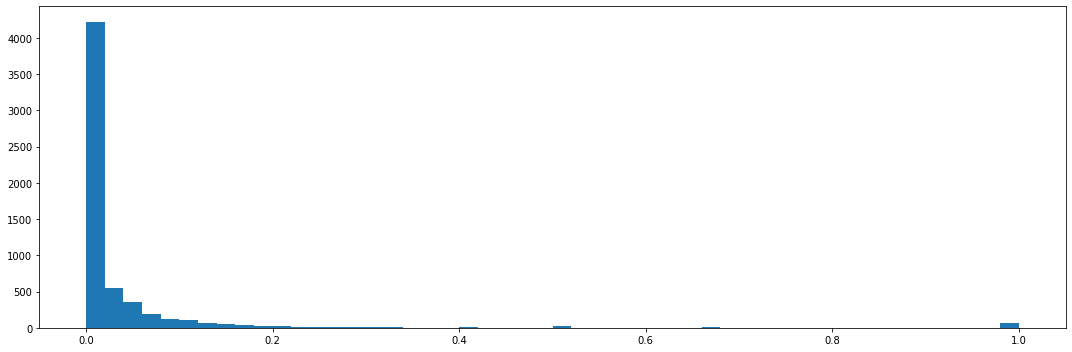

In [81]:
plt.hist(pd.Series(refund_history, name='Refund sum before 2011-11'), bins=50)
plt.tight_layout()

환불을 많이 한 고객 0.4 ~ 1.0까지 조금 존재하는 것을 볼 수 있지만, 대부분은 0.2 미만인 것을 볼 수 있다. 즉, 거의 환불을 하지 않는다.

## 4. Groupby Customer ID

이제는 `customer_id`를 기준으로 데이터프레임을 groupby시켜보자.

In [61]:
def make_time_series_data(train, time_format):
    # 날짜를 어떤 형식으로 처리할 건지 지정
    standard = ['customer_id'] + [time_format]
    data = train.copy()

    data[time_format] = pd.to_datetime(data.order_date).dt.strftime(time_format)
    data.order_date = pd.to_datetime(data.order_date)

    period = pd.date_range('2009-12-01', periods=(data.order_date.max() - data.order_date.min()).days+1, freq='1d')  # 2009-12-01 - 2011-11-30 기간
    customer_ids = np.repeat(data.customer_id.unique(), len(period))  # 기간만큼 customer_id 반복
    times = np.tile(period, len(data.customer_id.unique())) # customer_id만큼 기간 반복
    
    frame = pd.DataFrame({'customer_id': customer_ids, 'order_date': times})
    frame[time_format] = pd.to_datetime(frame.order_date).dt.strftime(time_format)

    # 월을 기준으로 groupby
    data_group = data.groupby(standard).sum().reset_index()
    frame_group = frame.groupby(standard).count().reset_index().drop(['order_date'], axis=1)

    # 병합
    df = pd.merge(frame_group, data_group, on=standard, how='left').fillna(0)
    df = df.rename(columns={time_format: 'standard'})

    return df

In [62]:
merged_df = make_time_series_data(df, '%Y-%m')

In [63]:
merged_df.head()

customer_id standard  quantity     price     total
0        12346  2009-12      26.0   31.3500  187.2750
1        12346  2010-01      19.0  200.4750  -22.2750
2        12346  2010-02       0.0    0.0000    0.0000
3        12346  2010-03       5.0   44.6325   44.6325
4        12346  2010-04       0.0    0.0000    0.0000

In [64]:
merged_df[merged_df.customer_id==12346]['country'] = 'United Kingdom'
merged_df

customer_id standard  quantity     price      total
0             12346  2009-12      26.0   31.3500   187.2750
1             12346  2010-01      19.0  200.4750   -22.2750
2             12346  2010-02       0.0    0.0000     0.0000
3             12346  2010-03       5.0   44.6325    44.6325
4             12346  2010-04       0.0    0.0000     0.0000
...             ...      ...       ...       ...        ...
141931        18287  2011-07       0.0    0.0000     0.0000
141932        18287  2011-08       0.0    0.0000     0.0000
141933        18287  2011-09       0.0    0.0000     0.0000
141934        18287  2011-10    1098.0   78.5895  1768.8000
141935        18287  2011-11       0.0    0.0000     0.0000

[141936 rows x 5 columns]

In [65]:
def get_country(customer_id):
    country = df[df.customer_id==customer_id].country.unique()[0]
    return country

merged_df['country'] = merged_df['customer_id'].apply(get_country)
merged_df.head()

customer_id standard  quantity     price     total         country
0        12346  2009-12      26.0   31.3500  187.2750  United Kingdom
1        12346  2010-01      19.0  200.4750  -22.2750  United Kingdom
2        12346  2010-02       0.0    0.0000    0.0000  United Kingdom
3        12346  2010-03       5.0   44.6325   44.6325  United Kingdom
4        12346  2010-04       0.0    0.0000    0.0000  United Kingdom

In [66]:
merged_df.describe()

customer_id       quantity          price          total
count  141936.000000  141936.000000  141936.000000  141936.000000
mean    15319.245012      69.415201      33.768805     185.399869
std      1713.863559     699.595940     415.779768    1276.916742
min     12346.000000  -87167.000000       0.000000  -41433.298500
25%     13837.000000       0.000000       0.000000       0.000000
50%     15319.500000       0.000000       0.000000       0.000000
75%     16805.000000       0.000000       0.000000       0.000000
max     18287.000000   90726.000000   66460.185000  115906.725000

- 2009, 2010년에는 자주 구매를 했다가 2011년에 구매를 하지 않는 사람도 있고 주기적으로 구매하는 고객도 있다.
    - 최근 구매 기록을 피처로 넣을 필요가 있다.
    - 데이터 자체를 sequential하게 두고 RNN계열 모델을 사용하는 것도 좋을 것 같다.

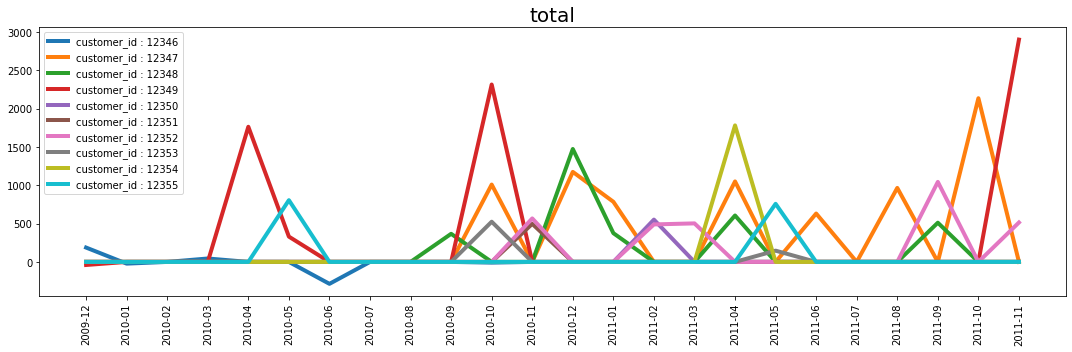

In [67]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['lines.linewidth'] = 4

# 10명 고객의 구매 추이
for customer_id in merged_df.customer_id.unique()[:10]:
    sub = merged_df[merged_df.customer_id==customer_id][['standard', 'total']]
    
    plt.plot(sub.standard, sub.total, label=f'customer_id : {customer_id}')
    plt.legend()
    plt.xticks(rotation=90)
    plt.title('total', size=20)
    plt.tight_layout()

smoothing을 적용해서 구매 경향을 확인해보자.

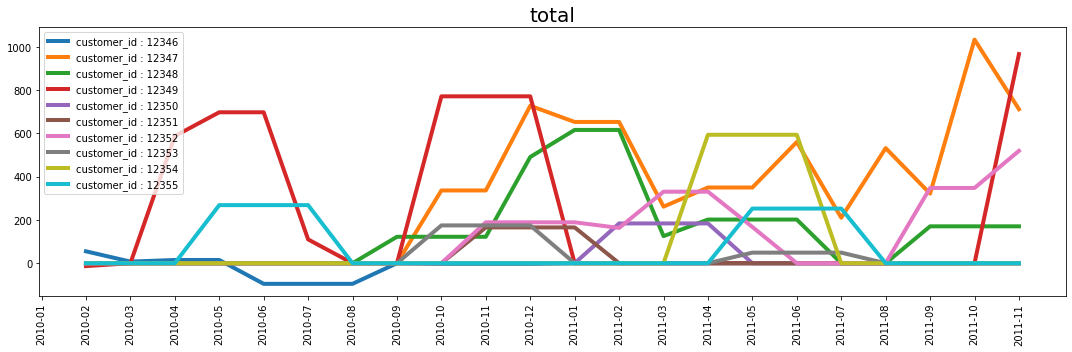

In [68]:
# smoothing을 적용한 10명 고객의 구매 추이
for customer_id in merged_df.customer_id.unique()[:10]:
    sub = merged_df[merged_df.customer_id==customer_id][['standard', 'total']]
    
    plt.plot(sub.standard, sub.total.rolling(window=3).mean(), label=f'customer_id : {customer_id}')
    plt.legend()
    plt.xticks(rotation=90)
    plt.title('total', size=20)
    plt.tight_layout()

### 4.1. total과 refund

In [76]:
valid_target = merged_df[merged_df.standard == '2011-11']['total']
valid_target.head()

23        0.0000
47        0.0000
71        0.0000
95     2899.9575
119       0.0000
Name: total, dtype: float64

Text(0.6, 40000, 'Correlation between x and y is -0.016')

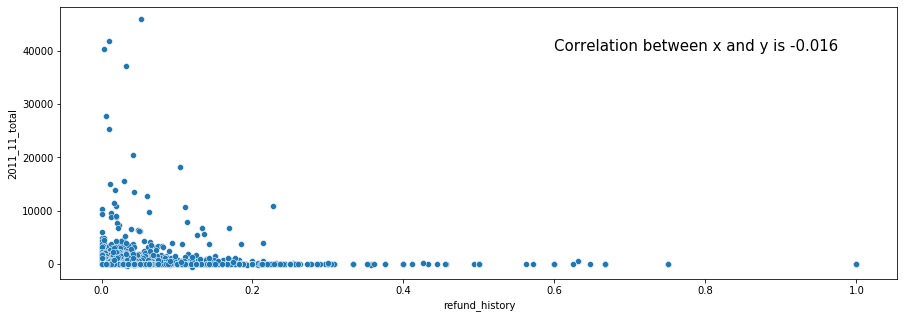

In [82]:
data = pd.DataFrame({'2011_11_total': np.array(valid_target), 'refund_history': np.array(refund_history)})
sns.scatterplot(data=data, x='refund_history', y='2011_11_total')
plt.text(0.6, 40000, s='Correlation between x and y is -0.016', size=15)

In [83]:
np.corrcoef(temp.groupby(['customer_id']).count().reset_index()['total'], valid_target)

array([[1.        , 0.52806752],
       [0.52806752, 1.        ]])

환불 비율과 `total`과는 연관성이 거의 없다. 하지만 구매건수와 `total`과는 연관성이 있다고 보인다. (total값이 결국 구매건수에 따라 올라가기 때문에 그럴 수 밖에 없음.)

### 3.2. 월별 상관관계

#### 3.2.1. total을 기준으로

In [90]:
corr = []
for year_month in merged_df.standard.unique()[:12]:
    corr_sub=np.corrcoef(merged_df[merged_df.standard == year_month].total, merged_df[merged_df.standard == "2010-12"].total)[0][1]
    corr.append(corr_sub)

In [92]:
corr

[0.7578604977282027,
 0.5055271770561938,
 0.5996527509875309,
 0.4831234989854199,
 0.5574099187524817,
 0.4971127628312578,
 0.45463991057830483,
 0.6969724694206112,
 0.6682408448130173,
 0.32036172957674197,
 0.5911833127463257,
 0.5686260532966214]

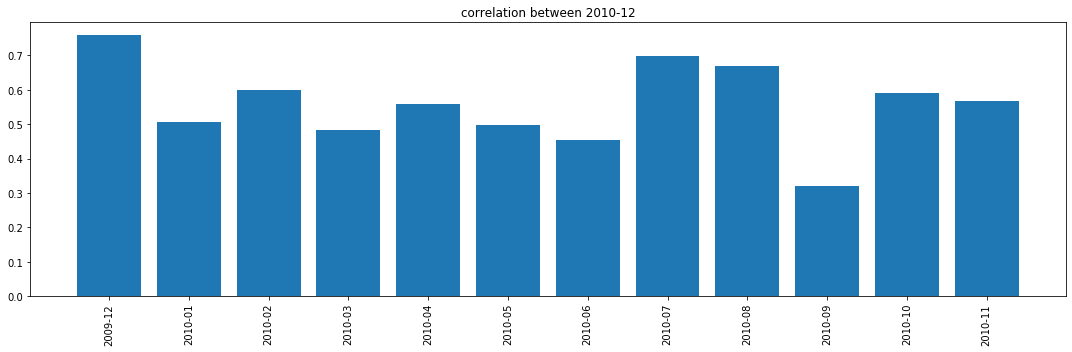

In [91]:
plt.bar(x=merged_df.standard.unique()[:12], height=corr)
plt.xticks(rotation=90)
plt.title('correlation between 2010-12')
plt.tight_layout()

작년 12월을 기준으로 `total`간의 상관관계를 살펴보면 재작년 12월, 작년 7월, 8월 순으로 연관이 있는 것을 볼 수 있다. 대부분 0.5 이상의 어느 정도 높은 상관관계를 보여준다.

In [95]:
df['year_month'] = pd.to_datetime(df.order_date).dt.strftime("%Y-%m")
df.head()

order_id product_id                          description  quantity  \
0   489434      85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434     79323P                   PINK CHERRY LIGHTS        12   
2   489434     79323W                  WHITE CHERRY LIGHTS        12   
3   489434      22041         RECORD FRAME 7" SINGLE SIZE         48   
4   489434      21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           order_date    price  customer_id         country   total year_month  
0 2009-12-01 07:45:00  11.4675        13085  United Kingdom  137.61    2009-12  
1 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65    2009-12  
2 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65    2009-12  
3 2009-12-01 07:45:00   3.4650        13085  United Kingdom  166.32    2009-12  
4 2009-12-01 07:45:00   2.0625        13085  United Kingdom   49.50    2009-12

In [96]:
standard = ['customer_id','year_month']
merged_df = pd.merge(merged_df, df.groupby(['customer_id','year_month']).count().reset_index()[standard + ['order_id']],
         left_on=['customer_id','standard'],
         right_on=['customer_id','year_month'], how='left').fillna(0)
merged_df.head()

customer_id standard  quantity     price     total         country  \
0        12346  2009-12      26.0   31.3500  187.2750  United Kingdom   
1        12346  2010-01      19.0  200.4750  -22.2750  United Kingdom   
2        12346  2010-02       0.0    0.0000    0.0000  United Kingdom   
3        12346  2010-03       5.0   44.6325   44.6325  United Kingdom   
4        12346  2010-04       0.0    0.0000    0.0000  United Kingdom   

  year_month  order_id  
0    2009-12       5.0  
1    2010-01       5.0  
2          0       0.0  
3    2010-03       5.0  
4          0       0.0

In [99]:
df.groupby(['customer_id','year_month']).count().reset_index()[standard + ['order_id']]
merged_df = merged_df.rename(columns={'order_id':'order_count'})
merged_df.head()

customer_id standard  quantity     price     total         country  \
0        12346  2009-12      26.0   31.3500  187.2750  United Kingdom   
1        12346  2010-01      19.0  200.4750  -22.2750  United Kingdom   
2        12346  2010-02       0.0    0.0000    0.0000  United Kingdom   
3        12346  2010-03       5.0   44.6325   44.6325  United Kingdom   
4        12346  2010-04       0.0    0.0000    0.0000  United Kingdom   

  year_month  order_count  
0    2009-12          5.0  
1    2010-01          5.0  
2          0          0.0  
3    2010-03          5.0  
4          0          0.0

In [107]:
corr = []
for year_month in merged_df.standard.unique()[:12]:
    corr_sub=np.corrcoef(merged_df[merged_df.standard == year_month].order_count,
                         merged_df[merged_df.standard == "2010-12"].total)[0][1]
    corr.append(corr_sub)

In [108]:
corr

[0.26135056926490413,
 0.2571347030421743,
 0.2515114817652595,
 0.23262313177597152,
 0.2586284945874329,
 0.22973191366450757,
 0.22042223766428612,
 0.26799804580517167,
 0.2637215110527022,
 0.2655089258802146,
 0.2145097653409814,
 0.24371876154759262]

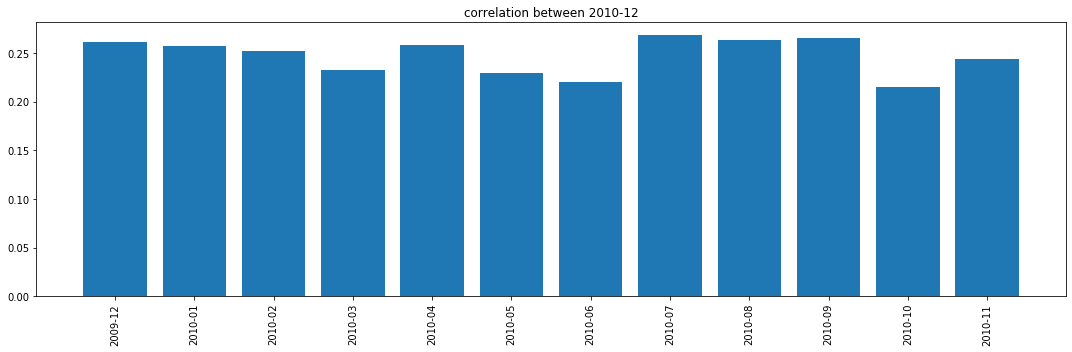

In [109]:
plt.bar(x=merged_df.standard.unique()[:12], height=corr)
plt.xticks(rotation=90)
plt.title('correlation between 2010-12')
plt.tight_layout()

count는 total과는 달리 큰 연관성은 보이지 않는다. 또한 값과 서로차이가 나질 않으므로 크게 신경쓰지 않아도 될 것 같다.

In [111]:
df['product_id_clean'] = ["".join(re.findall("[0-9]+", code)) for code in df.product_id]
df['product_id_clean'] = df.product_id_clean.replace(r'^\s*$', np.nan, regex=True)
df.dropna().head()

order_id product_id                          description  quantity  \
0   489434      85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434     79323P                   PINK CHERRY LIGHTS        12   
2   489434     79323W                  WHITE CHERRY LIGHTS        12   
3   489434      22041         RECORD FRAME 7" SINGLE SIZE         48   
4   489434      21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           order_date    price  customer_id         country   total  \
0 2009-12-01 07:45:00  11.4675        13085  United Kingdom  137.61   
1 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65   
2 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65   
3 2009-12-01 07:45:00   3.4650        13085  United Kingdom  166.32   
4 2009-12-01 07:45:00   2.0625        13085  United Kingdom   49.50   

  year_month product_id_clean  
0    2009-12            85048  
1    2009-12            79323  
2    2009-12            79323  
3    2009-12            22041  
4    2009-12            21232

In [113]:
df['product_id_clean_3'] = [code[0:2] for code in df.product_id_clean.astype("str")]
df.head()

order_id product_id                          description  quantity  \
0   489434      85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434     79323P                   PINK CHERRY LIGHTS        12   
2   489434     79323W                  WHITE CHERRY LIGHTS        12   
3   489434      22041         RECORD FRAME 7" SINGLE SIZE         48   
4   489434      21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           order_date    price  customer_id         country   total  \
0 2009-12-01 07:45:00  11.4675        13085  United Kingdom  137.61   
1 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65   
2 2009-12-01 07:45:00  11.1375        13085  United Kingdom  133.65   
3 2009-12-01 07:45:00   3.4650        13085  United Kingdom  166.32   
4 2009-12-01 07:45:00   2.0625        13085  United Kingdom   49.50   

  year_month product_id_clean product_id_clean_3  
0    2009-12            85048                 85  
1    2009-12            79323                 79  
2    2009-12            79323                 79  
3    2009-12            22041                 22  
4    2009-12            21232                 21

In [118]:
# product_id에서 앞 2자리만 뽑아 one hotencoding화 한이후에 year_month로 묶어 count를 세어줍니다.
temp = pd.concat([df[['customer_id','year_month']], 
      pd.get_dummies(df.product_id_clean_3)], axis=1).groupby(['customer_id','year_month']).sum().reset_index(drop=False)
temp.head()

customer_id year_month   00   10   11   15   16   17   18    2   20   21  \
0        12346    2009-12  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        12346    2010-01  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        12346    2010-03  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  2.0  0.0   
3        12346    2010-06  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  3.0   
4        12346    2010-10  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    22   23   35   37   40   44   45   46   47   48   51   62   70   71   72  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  9.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  6.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    75   77   78   79   81   82   84   85   90   na  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  9.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [121]:
merged_df[['customer_id', 'standard']].head()

customer_id standard
0        12346  2009-12
1        12346  2010-01
2        12346  2010-02
3        12346  2010-03
4        12346  2010-04

In [119]:
# 구매기록이 없는 경우에 0을 채워주기 위해서 앞서 만들었던 data frame과 merge해줍니다.
temp = pd.merge(merged_df[['customer_id', 'standard']], temp, left_on=['customer_id', 'standard'],
         right_on=['customer_id','year_month'], how='left').fillna(0)
temp.head()

customer_id standard year_month   00   10   11   15   16   17   18    2  \
0        12346  2009-12    2009-12  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        12346  2010-01    2010-01  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        12346  2010-02          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3        12346  2010-03    2010-03  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0   
4        12346  2010-04          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    20   21   22   23   35   37   40   44   45   46   47   48   51   62   70  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    71   72   75   77   78   79   81   82   84   85   90   na  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

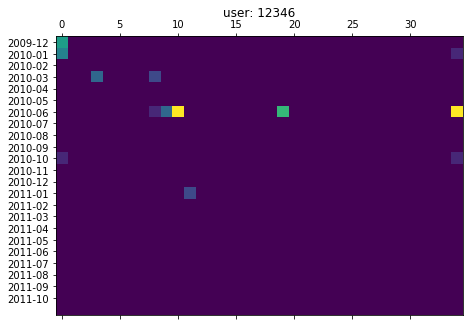

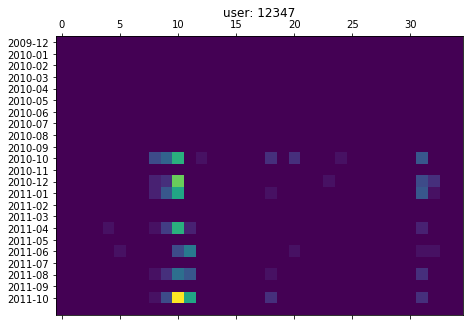

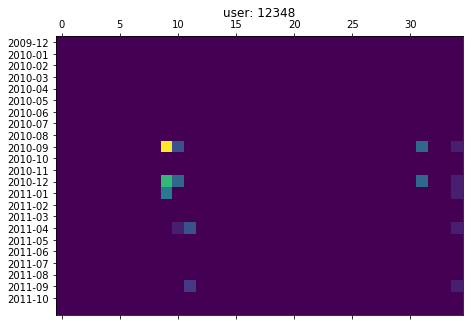

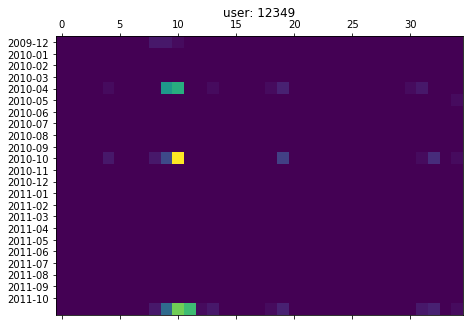

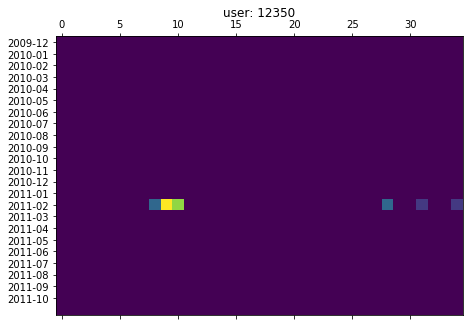

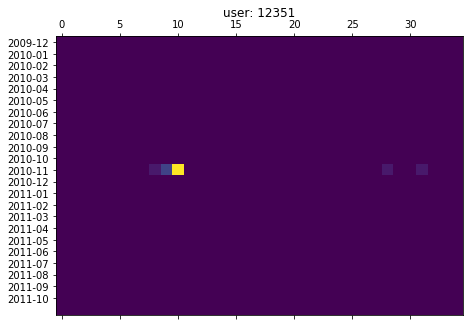

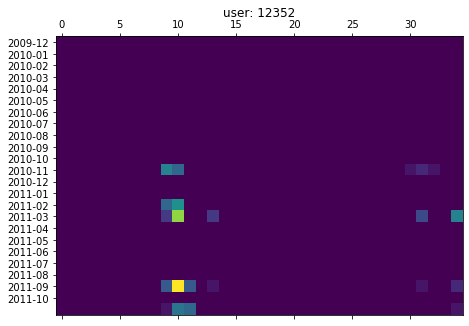

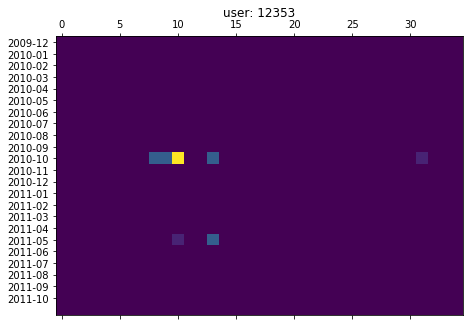

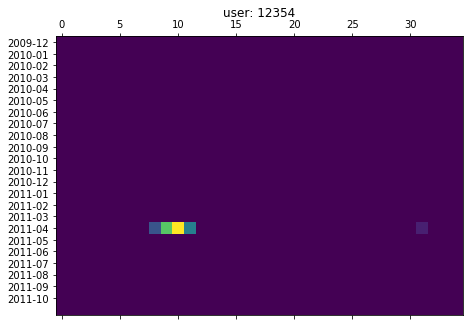

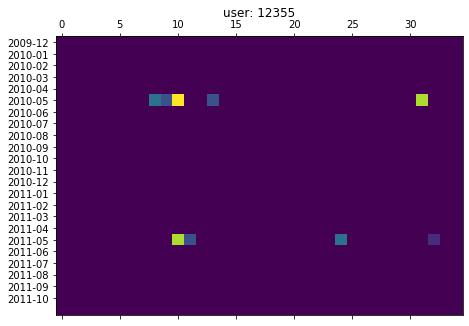

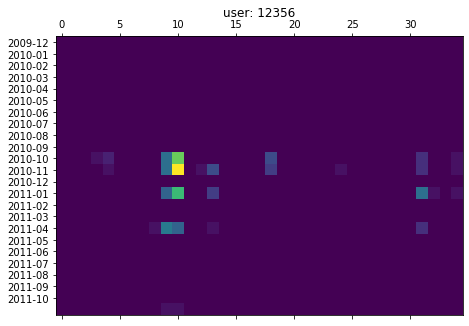

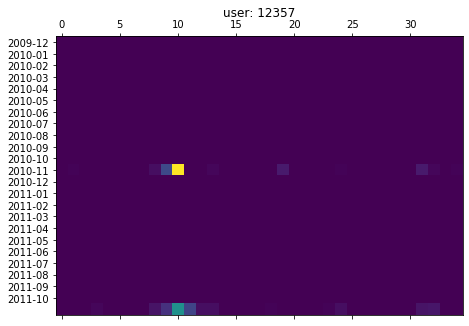

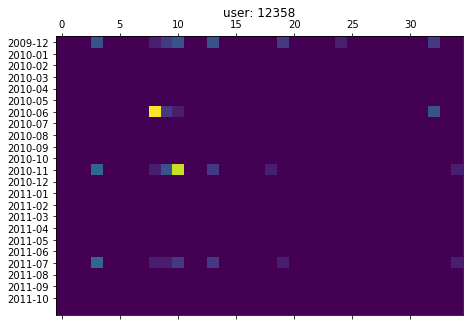

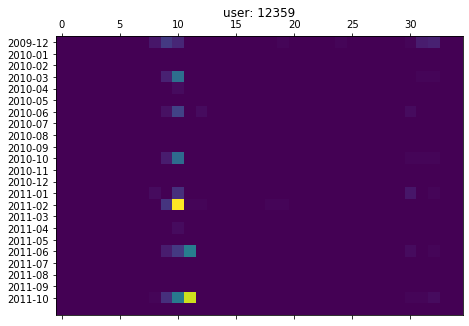

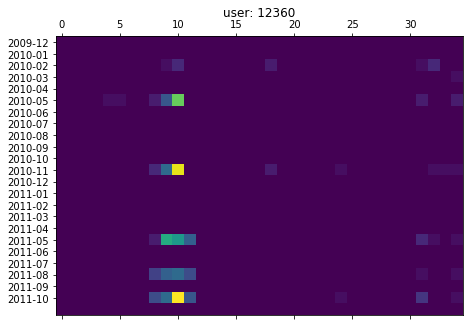

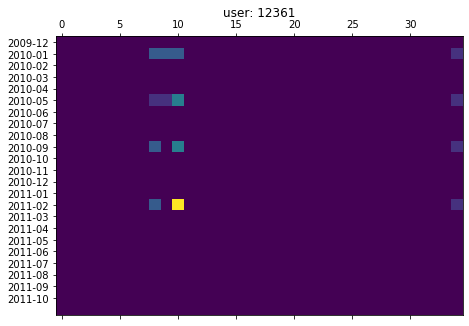

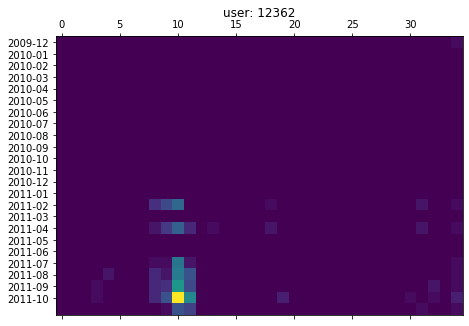

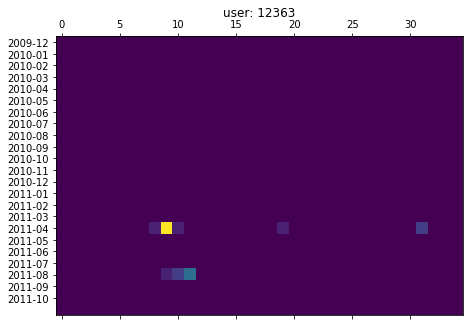

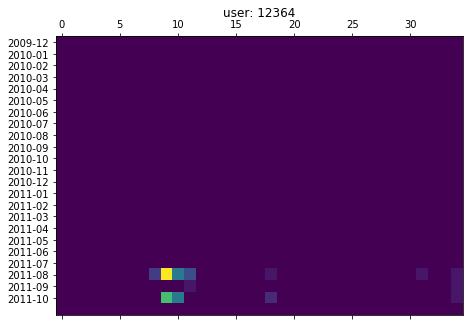

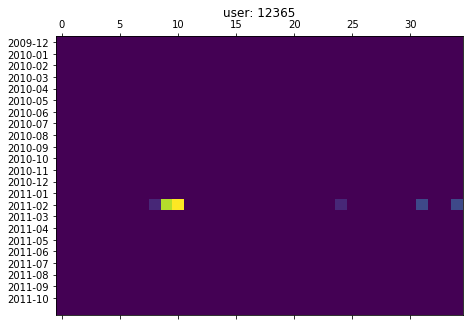

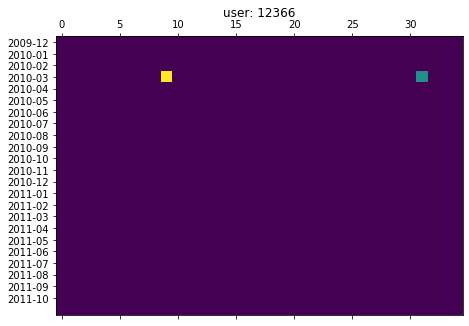

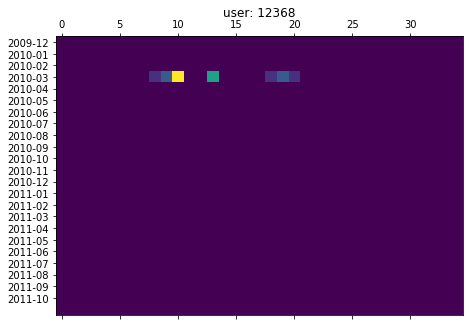

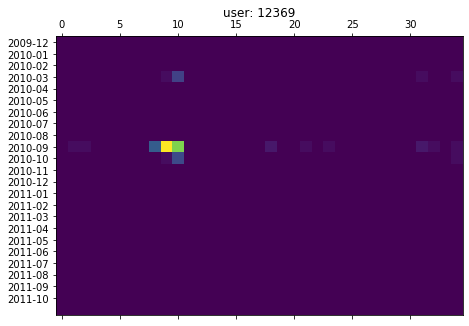

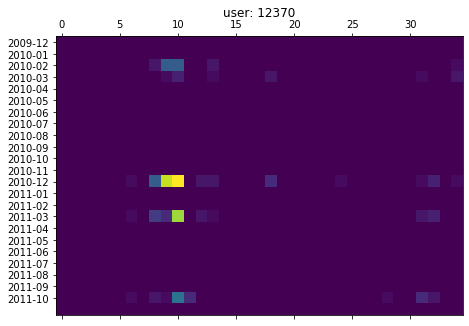

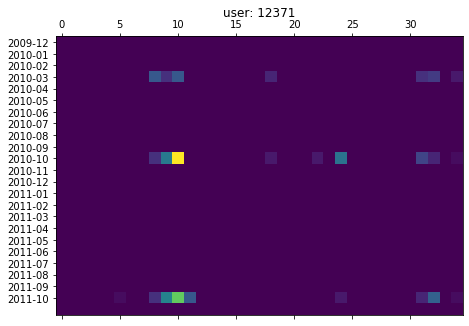

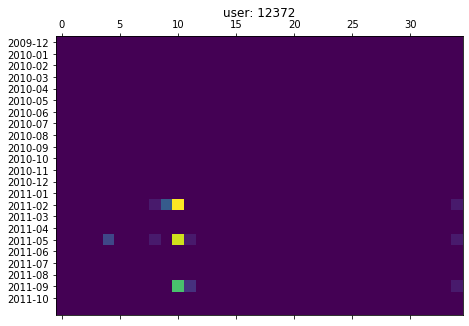

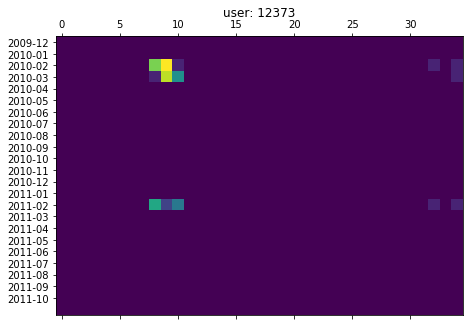

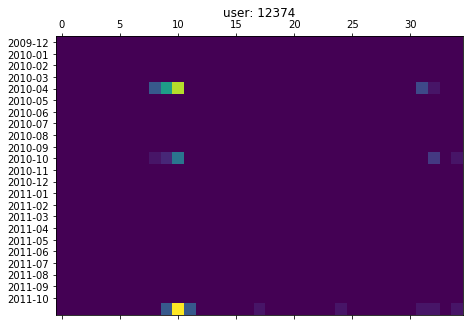

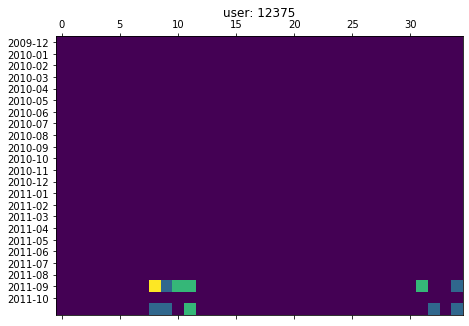

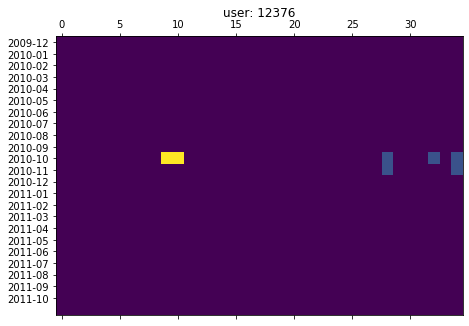

In [139]:
for customer in temp.customer_id.unique()[:30]:
    temp_customer = temp[temp.customer_id == customer]
    # x축은 물건 자릿수, y축은 2009-12 ~ 2011-11까지의 기간
    plt.matshow(temp_customer.drop(['customer_id','standard','year_month'], axis=1))
    plt.title(f'user: {customer}')
    plt.yticks(np.arange(23), list(merged_df.standard.unique()))
    plt.show()

꾸준히 구매하는 고객과 듬성듬성 구매하는 고객, 1회성으로 한 번정도 구매하는 고객정도로 나눌 수 있을 것 같다.